### DONE
- FT-HMC implemented for 8x8 2D QED (using SiLU as activation function).

- Try to minimize size of the force in training. No significant improvements.

- Some test on ergodicity

- (calculate the probablity of generating the configs obtained via conventional HMC).

### TODO

- Plot the force size distribution
- Is the large force from the original action or Field-Transformation the determinant?
- If from the determinant, then the fermion force won't cause problem for HMC

- Use the same Field-Transformation for larger system (say 16x16, 32x32, 64x64, etc)
- Study how the delta H depends on the system size ( perhaps delta H ~ sqrt(volume) )

- Study the auto-correlation for observables, topo, plaq, flowed plaq, etc.

- Improving the Field-Transformation to reduce force.

In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
import math
import sys
import os
from timeit import default_timer as timer
from functools import reduce

In [3]:
from datetime import datetime as dt

try:
    from rich.theme import Theme
    from rich.console import Console
    from rich.style import Style

    theme = Theme({
        'repr.number': 'bold bright_green',
        'repr.attrib_name': 'bold bright_magenta'
    })
    console = Console(record=False, log_path=False, width=256,
                      log_time_format='[%X] ', theme=theme)
    RICH = True
    def put(s):
        console.log(s)
    
    
except (ImportError, ModuleNotFoundError):
    RICH = False
    def put(s):
        print(s)

In [4]:
project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
    
from utils.param import Param
import utils.io as io
logger = io.Logger()

In [5]:
def print_metrics(history, avg_last_n_epochs=10, era=None, epoch=None):
    outstr = []
    
    if era is not None:
        outstr.append(f'era: {era}')
    if epoch is not None:
        outstr.append(f'epoch: {epoch}')
        
    for key, val in history.items():
        val = np.array(val)
        if len(val.shape) > 0:
            avgd = np.mean(val[-avg_last_n_epochs:])
        else:
            avgd = np.mean(val)
        outstr.append(f'{key}: {avgd:g}')
        
    outstr = ', '.join(outstr)
    put(outstr)
    
    return outstr

In [27]:
param=Param(
    beta=4.0,
    L=16,
    #lat=(16, 16),
    tau=1.5, # 0.3
    nstep=10, # 3
    nrun=4,
    # ADJUST ME
    ntraj=256, # 2**16 # 2**10 # 2**15
    nprint=10,
    seed=1331,
)

logger.log(repr(param))

[22:08:23]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=10                                                                                                                                                                                                                        
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

In [7]:
torch.manual_seed(param.seed)

torch.set_num_threads(param.nth)
torch.set_num_interop_threads(param.nth_interop)
os.environ["OMP_NUM_THREADS"] = str(param.nth)
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

#torch.set_default_tensor_type(torch.DoubleTensor)

In [28]:
import utils.qed_helpers as qed
import ipynb.field_transformation as ft
import datetime

NOW = io.get_timestamp('%Y-%m-%d')
OUTDIR = os.path.join(os.getcwd(), 'outputs', NOW)
if not os.path.isdir(OUTDIR):
    os.makedirs(OUTDIR)

    
def run(param, field=None, keep_fields=False, outdir=None):
    if field is None:
        field = param.initializer()
        
    if outdir is None:
        outdir = OUTDIR
        
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
        
    fields = {i: [] for i in range(param.nrun)}
    metrics = {
        'dt': [],
        'accept': [],
        'traj': [],
        'dH': [],
        'expdH': [],
        'plaq': [],
        'charge': [],
    }
        
    outfile = os.path.join(outdir, param.uniquestr())
    logger.log(f'outfile: {outfile}')
    with open(outfile, 'w') as f:
        #params = param.summary()
        f.write(repr(param))
        logger.log(repr(param))
        plaq = qed.action(param, field)
        charge = qed.topo_charge(field[None, :])
        status = (f'Initial configuration: '
                  f'\t plaq={plaq} '
                  f'\t charge={qed.grab(charge)[0]}\n')
        f.write(status)
        logger.log(status)
        #ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                dH, exp_mdH, acc, field = qed.hmc(param, field, verbose=False)
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                charge = qed.topo_charge(field[None, :])
                #topo1 = qed.topo_charge1(field[None, :])
                ifacc = "True" if acc else "False"
                observables = {
                    'traj': n * param.ntraj + i + 1,
                    #'accept': bool(acc),
                    'accept': ifacc,
                    'dH': dH,
                    'expdH': exp_mdH,
                    'plaq': plaq,
                    'charge': int(qed.grab(charge)[0]),
                }
                
                #status = {
                #    k: f'{v:<12.8g}' if isinstance(v, float) 
                #    else f'{v:<4}' for k, v in observables.items()
                #}
                
                #outstr = ', '.join(
                #    '='.join((k, v)) for k, v in status.items()
                #)
                #f.write(outstr + '\n')
                
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    outstr = io.print_metrics(observables, logger=logger)
                    f.write(outstr + '\n')
                    #logger.log(outstr)
                    
                if keep_fields:
                    fields[n].append(field)
                else:
                    fields[n] = field
                    
            t += timer()
            
            metrics['dt'].append(t)
            for key, val in observables.items():
                metrics[key].append(val)
            
        dt = metrics['dt']
        logger.log(f'Run times: {dt}')
        logger.log(f'Per trajectory: {[t / param.ntraj for t in dt]}')
        
    return fields, metrics

In [29]:
fields, metrics = run(param, keep_fields=False)

[22:08:52]  outfile: /lus/grand/projects/DLHMC/nftqcd/fthmc/flow_test_sam/notebooks/outputs/2021-05-18/out_l16.16_b4.0_n256_t1.5_s10.out

[22:08:53]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=10                                                                                                                                                                                                                        
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

            Initial configuration:   plaq=-1024.0    charge=0.0

            traj=25    accept=True  dH=0.579895 expdH=0.559957 plaq=0.880853 charge=0

            traj=50    accept=True  dH=-0.565063 expdH=1.75956 plaq=0.86132 charge=0

            traj=75    accept=False dH=1.66663 expdH=0.188883 plaq=0.858985 charge=-1

            traj=100   accept=False dH=1.56232 expdH=0.20965 plaq=0.857386 charge=-2

            traj=125   accept=False dH=1.73676 expdH=0.176091 plaq=0.83361 charge=0

            traj=150   accept=True  dH=0.704712 expdH=0.494251 plaq=0.868878 charge=1

            traj=175   accept=True  dH=-0.688843 expdH=1.99141 plaq=0.864389 charge=0

            traj=200   accept=True  dH=-1.52405 expdH=4.59077 plaq=0.851023 charge=0

            traj=225   accept=True  dH=-0.490662 expdH=1.6334 plaq=0.879556 charge=-1

            traj=250   accept=False dH=0.561707 expdH=0.570235 plaq=0.874887 charge=-1

            traj=281   accept=False dH=0.687073 expdH=0.503046 plaq=0.847361 charge=-1

            traj=306   accept=True  dH=-0.0363159 expdH=1.03698 plaq=0.866545 charge=-1

            traj=331   accept=True  dH=1.25171 expdH=0.286016 plaq=0.877389 charge=0

            traj=356   accept=True  dH=-0.821045 expdH=2.27287 plaq=0.853319 charge=0

[22:08:54]  traj=381   accept=True  dH=-0.133423 expdH=1.14273 plaq=0.870469 charge=0

            traj=406   accept=False dH=1.16522 expdH=0.311853 plaq=0.862331 charge=0

            traj=431   accept=False dH=1.09869 expdH=0.333306 plaq=0.842903 charge=1

            traj=456   accept=True  dH=0.309814 expdH=0.733583 plaq=0.853692 charge=3

            traj=481   accept=True  dH=2.31055 expdH=0.099207 plaq=0.864498 charge=3

            traj=506   accept=False dH=0.565063 expdH=0.568324 plaq=0.851255 charge=0

            traj=537   accept=True  dH=0.461182 expdH=0.630538 plaq=0.87449 charge=1

            traj=562   accept=True  dH=0.582642 expdH=0.558421 plaq=0.870805 charge=2

            traj=587   accept=True  dH=-0.249878 expdH=1.28387 plaq=0.852385 charge=1

            traj=612   accept=True  dH=0.0180664 expdH=0.982096 plaq=0.858588 charge=0

            traj=637   accept=False dH=0.918884 expdH=0.398964 plaq=0.859648 charge=-1

            traj=662   accept=True  dH=-1.08997 expdH=2.97417 plaq=0.853584 charge=-2

            traj=687   accept=False dH=1.18518 expdH=0.305691 plaq=0.87224 charge=0

            traj=712   accept=True  dH=-1.87567 expdH=6.5252 plaq=0.870883 charge=-1

            traj=737   accept=True  dH=1.00012 expdH=0.367835 plaq=0.865063 charge=0

[22:08:55]  traj=762   accept=False dH=2.24493 expdH=0.105935 plaq=0.859786 charge=0

            traj=793   accept=False dH=0.852722 expdH=0.426253 plaq=0.853333 charge=0

            traj=818   accept=False dH=1.90912 expdH=0.148211 plaq=0.85215 charge=1

            traj=843   accept=False dH=2.28955 expdH=0.101312 plaq=0.848822 charge=0

            traj=868   accept=False dH=0.554199 expdH=0.574532 plaq=0.869688 charge=0

            traj=893   accept=True  dH=0.901062 expdH=0.406138 plaq=0.880024 charge=0

            traj=918   accept=False dH=1.81464 expdH=0.162897 plaq=0.875795 charge=0

            traj=943   accept=False dH=0.77063 expdH=0.462722 plaq=0.865332 charge=0

            traj=968   accept=True  dH=0.748596 expdH=0.47303 plaq=0.870564 charge=0

            traj=993   accept=True  dH=0.949036 expdH=0.387114 plaq=0.873762 charge=0

            traj=1018  accept=False dH=0.444153 expdH=0.641367 plaq=0.863266 charge=1

            Run times: [0.6743555064313114, 0.6755551411770284, 0.6821423810906708, 0.6729114078916609]

            Per trajectory: [0.00263420119699731, 0.0026388872702227673, 0.002664618676135433, 0.0026285601870768005]

In [119]:
from train import run as train_run

_fields, _metrics = train_run(param, logger=logger)

[02:40:41]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=10                                                                                                                                                                                                                        
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

            plaq=1     charge=0

            traj=25    accept=0     dH=1.432 expdH=0.2388 plaq=0.8678 charge=7.589e-07

            traj=50    accept=0     dH=1.984 expdH=0.1375 plaq=0.8708 charge=-2

            traj=75    accept=1     dH=0.884 expdH=0.4131 plaq=0.8719 charge=-1

            traj=100   accept=1     dH=0.08069 expdH=0.9225 plaq=0.8808 charge=0

            traj=125   accept=0     dH=1.757 expdH=0.1725 plaq=0.8367 charge=-1

            traj=150   accept=0     dH=1.318 expdH=0.2676 plaq=0.8453 charge=-2

[02:40:42]  traj=175   accept=1     dH=1.306 expdH=0.271 plaq=0.8658 charge=-2

            traj=200   accept=1     dH=0.2503 expdH=0.7786 plaq=0.8635 charge=-2

            traj=225   accept=1     dH=-0.2706 expdH=1.311 plaq=0.8798 charge=-2

            traj=250   accept=0     dH=1.556 expdH=0.2111 plaq=0.858 charge=1.518e-07

            traj=281   accept=1     dH=-0.01379 expdH=1.014 plaq=0.8607 charge=1.138e-07

            traj=306   accept=1     dH=-0.1357 expdH=1.145 plaq=0.8424 charge=-2

[02:40:43]  traj=331   accept=0     dH=0.6514 expdH=0.5213 plaq=0.8543 charge=-2

            traj=356   accept=1     dH=-0.3211 expdH=1.379 plaq=0.8672 charge=-1

            traj=381   accept=1     dH=0.1274 expdH=0.8804 plaq=0.8532 charge=3.036e-07

            traj=406   accept=0     dH=2.942 expdH=0.05274 plaq=0.8414 charge=-6.071e-07

            traj=431   accept=0     dH=1.055 expdH=0.348 plaq=0.8523 charge=1

            traj=456   accept=0     dH=2.419 expdH=0.089 plaq=0.8418 charge=2

            traj=481   accept=1     dH=0.2022 expdH=0.8169 plaq=0.8699 charge=2

[02:40:44]  traj=506   accept=1     dH=0.2077 expdH=0.8124 plaq=0.8829 charge=1

            traj=537   accept=1     dH=-0.601 expdH=1.824 plaq=0.8805 charge=1

            traj=562   accept=1     dH=0.4922 expdH=0.6113 plaq=0.8765 charge=1

            traj=587   accept=0     dH=2.514 expdH=0.08092 plaq=0.8313 charge=1

            traj=612   accept=1     dH=1.017 expdH=0.3617 plaq=0.8506 charge=-7.589e-08

            traj=637   accept=0     dH=1.92  expdH=0.1466 plaq=0.8375 charge=7.21e-07

[02:40:45]  traj=662   accept=0     dH=0.8444 expdH=0.4298 plaq=0.8667 charge=2

            traj=687   accept=0     dH=1.478 expdH=0.2282 plaq=0.8716 charge=2

            traj=712   accept=1     dH=-0.9858 expdH=2.68  plaq=0.8635 charge=3

            traj=737   accept=1     dH=-0.1426 expdH=1.153 plaq=0.8813 charge=2

            traj=762   accept=1     dH=0.3162 expdH=0.7289 plaq=0.8666 charge=1

            traj=793   accept=1     dH=0.7222 expdH=0.4857 plaq=0.8736 charge=7.969e-07

[02:40:46]  traj=818   accept=0     dH=0.9476 expdH=0.3877 plaq=0.8662 charge=1

            traj=843   accept=0     dH=1.23  expdH=0.2923 plaq=0.8739 charge=1

            traj=868   accept=0     dH=0.8506 expdH=0.4272 plaq=0.8848 charge=2

            traj=893   accept=0     dH=0.4017 expdH=0.6692 plaq=0.8928 charge=1

            traj=918   accept=1     dH=0.09552 expdH=0.9089 plaq=0.8698 charge=-1

            traj=943   accept=0     dH=0.5427 expdH=0.5812 plaq=0.8601 charge=-4.553e-07

            traj=968   accept=0     dH=0.9576 expdH=0.3838 plaq=0.8663 charge=1

[02:40:47]  traj=993   accept=0     dH=1.402 expdH=0.246 plaq=0.8701 charge=1

            traj=1018  accept=1     dH=0.4379 expdH=0.6454 plaq=0.8607 charge=-1

            Run times: [1.5561013221740723, 1.5528874397277832, 1.558138132095337, 1.5599679946899414]

            Per trajectory: [0.00607852078974247, 0.006065966561436653, 0.00608647707849741, 0.006093624979257584]

## Helper functions for training model

In [32]:
logger = io.Logger()
logger.rule('testing', width=150)

[22:14:09]  --------------------------------------------------------------------- testing ---------------------------------------------------------------------

In [65]:
import time
import utils.qed_helpers as qed
from typing import Callable

import torch.nn as nn

from utils.layers import make_u1_equiv_layers, set_weights
from utils.distributions import MultivariateUniform, bootstrap, calc_dkl, calc_ess
from utils.samplers import make_mcmc_ensemble, apply_flow_to_prior

from utils.plot_helpers import (init_live_joint_plots, update_joint_plots,
                                init_live_plot, update_plot)

grab = qed.grab

def train_step(
        model,
        action,
        optimizer,
        #metrics,
        batch_size,
        with_force=False,
        pre_model=None,
        verbose=True,
        era=None,
        epoch=None,
        #gamma=None,  # annealing factor, should be in [0, 1]
):
    t0 = time.time()
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    
    xi = None
    if pre_model != None:
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(batch_size)
        x = qed.ft_flow(pre_layers, pre_xi)
        xi = qed.ft_flow_inv(layers, x)
        
    xi, x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size, xi=xi)#, gamma=gamma)
    logp = -action(x)
    
    force_size = torch.tensor(0.0)
    dkl = calc_dkl(logp, logq)
    loss_force = torch.tensor(0.0)
    loss_dkl = torch.tensor(0.0)
    if with_force:
        assert pre_model != None
        force = qed.ft_force(param, layers, xi, True)
        force_size = torch.sum(torch.square(force))
        loss_force = force_size
        loss_force.backward()
    else:
        loss_dkl = dkl
        loss_dkl.backward()
        
    #loss.backward()
    #
    # minimization target
    # loss mini
    # -> (logq - logp) mini
    # -> (action - logJ) mini
    #
    optimizer.step()
    ess = calc_ess(logp, logq)
    batch_metrics = {
        'dt': time.time() - t0,
        #'loss': grab(loss),
        'loss_force': grab(loss_force),
        'loss': grab(loss_dkl),
        'force': grab(force_size),
        'dkl': grab(dkl),
        'logp': grab(logp),
        'logq': grab(logq),
        'ess': grab(ess),
        'force_norm': grab(torch.linalg.norm(qed.ft_force(param, layers, xi))),
    }
    #if verbose:
    #    io.print_metrics(batch_metrics)
    #    #ioprint_metrics(batch_metrics, era=era, epoch=epoch)
        
    return batch_metrics
        
                
                
def update_history(history, metrics, extras=None):
    if extras is not None:
        for key, val in extras.items():
            try:
                history[key].append(val)
            except KeyError:
                history[key] = [val]
                
    for key, val in metrics.items():
        try:
            history[key].append(val)
        except KeyError:
            history[key] = [val]

    return history

            
def flow_train(
    param,
    n_era=10,
    n_epoch=100,
    n_layers=24,
    n_s_nets=2,
    hidden_sizes=[8, 8],
    kernel_size=3,
    base_lr=0.001,
    batch_size=64,
    print_freq=10,
    plot_freq=20,
    with_force=False,
    pre_model=None
):  # packaged from original ipynb by Xiao-Yong Jin
    # Theory
    lattice_shape = tuple(param.lat)
    link_shape = (2,*param.lat)
    beta = param.beta
    #u1_action = U1GaugeAction(beta)
    u1_action = qed.BatchAction(param.beta)
    # Model
    prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
    
    layers = make_u1_equiv_layers(lattice_shape=lattice_shape,
                                  n_layers=n_layers,
                                  n_mixture_comps=n_s_nets,
                                  hidden_sizes=hidden_sizes,
                                  kernel_size=kernel_size)
    set_weights(layers)
    
    model = {'layers': layers, 'prior': prior}
    
    # Training
    optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)
    optimizer_wf = torch.optim.Adam(model['layers'].parameters(), lr=base_lr / 100.0)
    #
    history = {
        'era': [], 'epoch': [],
        'dt': [], 'force' : [], 'force_norm': [], 'ess' : [],
        'dkl' : [], 'logp' : [], 'logq' : [],
        'loss': [], 'loss_force': [],
    }
                
    dt = 0.0
    history.update({'loss': []})
    plots = init_live_joint_plots(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param)
    
    if with_force:
        y_label = ['ESS', 'loss_force']
        force_plots = init_live_joint_plots(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param, y_label=y_label)
        force_optimizer = torch.optim.Adam(model['layers'].parameters(),
                                           lr=base_lr / 100.0, weight_decay=1e-5)
        history.update({
            'loss_force': [], 
        })
        
    for era in range(n_era):
        t0 = time.time()
        #console.rule(f'ERA: {era} (last took: {int(dt // 60)} min {dt % 60:.4g}s)', style='bright_yellow')
        logger.rule(f'ERA={era} (last took: {int(dt // 60)} min {dt % 60:.4g}s)', width=75, style='bright_yellow')
        for epoch in range(n_epoch):
            if with_force:
                batch_metrics = train_step(model, u1_action, optimizer_wf, #history,
                                           batch_size, with_force=with_force, pre_model=pre_model,
                                           verbose=(epoch%print_freq==0), era=era, epoch=epoch)
            else:
                batch_metrics = train_step(model, u1_action, optimizer, #history,
                                           batch_size, era=era, epoch=epoch,
                                           verbose=(epoch%print_freq==0))
                
            history = update_history(history, batch_metrics,
                                     extras={'era': era, 'epoch': epoch})
                
            if (epoch + 1) % param.nprint == 0:
                running_avgs = io.running_averages(history,
                                                   n_epochs=min(epoch, 5))
                io.print_metrics(running_avgs, logger=logger)
                
            if epoch % plot_freq == 0:
                if with_force:
                    update_joint_plots(history, alt_loss='loss_force', **force_plots)
                    
                update_joint_plots(history, **plots)
        
        dt = time.time() - t0
        
    outputs = {
        'model': model,
        'history': history,
        'action': u1_action,
    }
    
    return outputs


ActionFn = Callable[[float], torch.Tensor]


def generate_ensemble(
    model: nn.Module,
    u1_action: ActionFn = qed.BatchAction,
    ensemble_size: int = 1024,
    batch_size: int = 64,
    nboot: int = 100,
    binsize: int = 16,
):
    """Calculate the topological susceptibility.
    
    Packaged from original ipynb by Xiao-Yong Jin.
    """
    u1_ens = make_mcmc_ensemble(model, u1_action, batch_size, ensemble_size)
    Q = qed.grab(qed.topo_charge(torch.stack(u1_ens['x'], axis=0)))
    X_mean, X_err = bootstrap(Q**2, nboot=nboot, binsize=16)
    
    put(f'Accept rate: {np.mean(u1_ens["accepted"])}')
    put(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
    put(f'... vs HMC estimate = 1.23 +/- 0.02')
    
    return u1_ens

## Train model without force:

In [ ]:
train_params = {
    'n_era': 10,
    'n_epoch': 500,
    'n_layers': 16,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8, 16, 8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 10,
    'plot_freq': 10,
}

outputs = flow_train(param, **train_params)

pre_flow_model = outputs['model']
pre_flow_history = outputs['history']
flow_act = outputs['action']

### Evaluate trained model and calculate topological susceptibility $\chi_{\mathcal{Q}}$

In [61]:
u1_ens = generate_ensemble(pre_flow_model,flow_act)
pre_flow = pre_flow_model['layers']

[23:25:05]  Accept rate: 0.01953125

            Topological susceptibility = 4.98 +/- 0.75

            ... vs HMC estimate = 1.23 +/- 0.02

### Save `model.state_dict()` to `./pre_flow_model/pre_flow_model_layers.pth`:

In [62]:
#model_dir = os.path.join(os.getcwd(), 'pre_flow_model') 
model_dir = os.path.join(OUTDIR, 'pre_flow_model')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

layers_file = os.path.join(model_dir, 'pre_flow_model_layers.pth')
torch.save(pre_flow_model['layers'].state_dict(), layers_file)

In [63]:
train_force = False
flow_model = None

if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
u1_ens = generate_ensemble(flow_model,flow_act)
flow = flow_model['layers']
# flow.eval()

[23:30:16]  Accept rate: 0.01171875

            Topological susceptibility = 2.56 +/- 0.36

            ... vs HMC estimate = 1.23 +/- 0.02

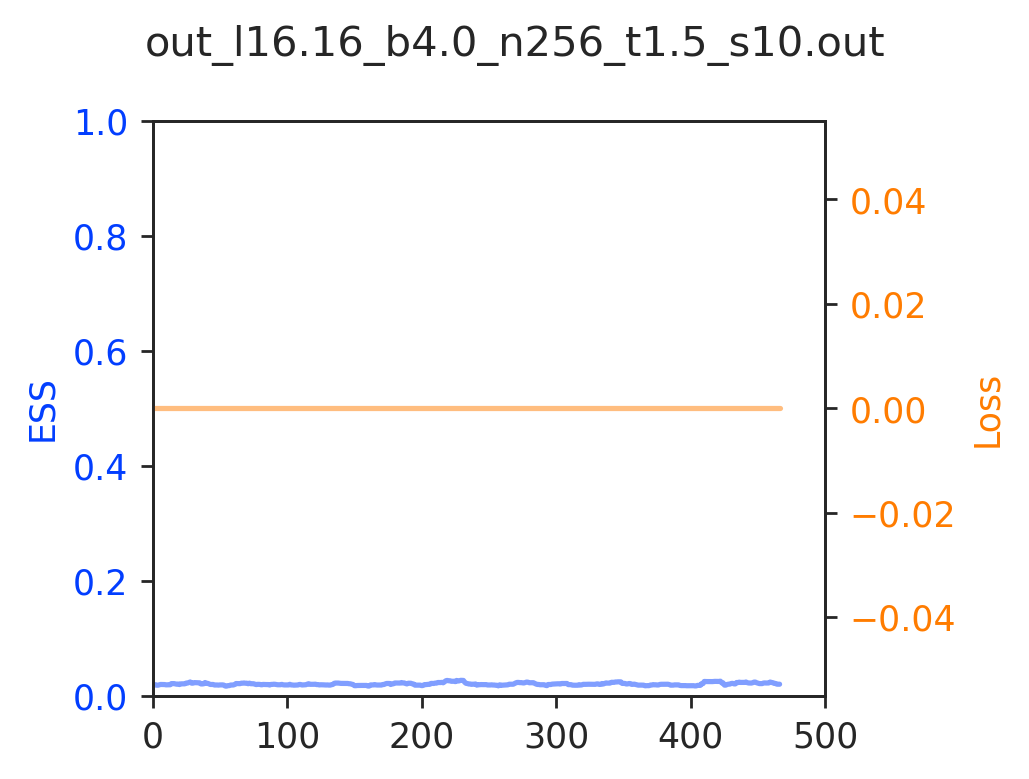

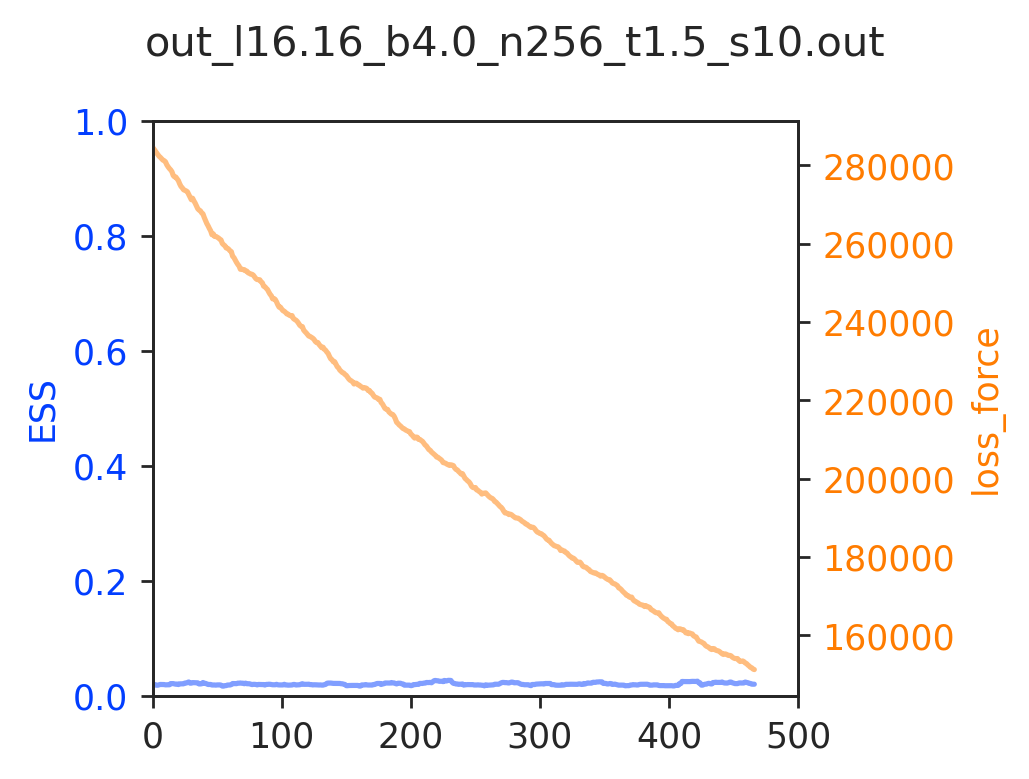

[00:06:55]  ---------------------- ERA=0 (last took: 0 min 0s) ----------------------                                                                                                                                                        
                                                                                                                                                                                                                                             

[00:07:03]  era=0     epoch=7     dt=0.6738 force=283103 force_norm=531.336 ess=0.018423 dkl=-1815.34 logp=856.198 logq=-959.146 loss=0     loss_force=283103

[00:07:11]  era=0     epoch=17    dt=0.6718 force=280491 force_norm=528.874 ess=0.0225762 dkl=-1815.58 logp=857.899 logq=-957.678 loss=0     loss_force=280491

[00:07:19]  era=0     epoch=27    dt=0.672 force=275948 force_norm=524.58 ess=0.0222224 dkl=-1814.04 logp=857.858 logq=-956.186 loss=0     loss_force=275948

[00:07:27]  era=0     epoch=37    dt=0.6711 force=271304 force_norm=520.152 ess=0.026151 dkl=-1811.63 logp=856.942 logq=-954.686 loss=0     loss_force=271304

[00:07:36]  era=0     epoch=47    dt=0.6714 force=266723 force_norm=515.735 ess=0.0193149 dkl=-1811.13 logp=857.856 logq=-953.271 loss=0     loss_force=266723

[00:07:44]  era=0     epoch=57    dt=0.6722 force=258527 force_norm=507.77 ess=0.0159283 dkl=-1811.24 logp=859.378 logq=-951.859 loss=0     loss_force=258527

[00:07:52]  era=0     epoch=67    dt=0.6714 force=258800 force_norm=508.036 ess=0.0172283 dkl=-1808.5 logp=858.158 logq=-950.339 loss=0     loss_force=258800

[00:08:00]  era=0     epoch=77    dt=0.6711 force=253061 force_norm=502.387 ess=0.023803 dkl=-1807.27 logp=858.354 logq=-948.921 loss=0     loss_force=253061

[00:08:08]  era=0     epoch=87    dt=0.6735 force=251101 force_norm=500.434 ess=0.0188278 dkl=-1805.24 logp=857.703 logq=-947.533 loss=0     loss_force=251101

[00:08:16]  era=0     epoch=97    dt=0.672 force=250016 force_norm=499.361 ess=0.0191829 dkl=-1801.32 logp=855.245 logq=-946.072 loss=0     loss_force=250016

            --------------------- ERA=1 (last took: 1 min 21s) ---------------------                                                                                                                                                         
                                                                                                                                                                                                                                             

[00:08:24]  era=1     epoch=7     dt=0.6713 force=243287 force_norm=492.598 ess=0.0173842 dkl=-1802.09 logp=857.396 logq=-944.691 loss=0     loss_force=243287

[00:08:32]  era=1     epoch=17    dt=0.6717 force=240124 force_norm=489.385 ess=0.0193158 dkl=-1800.78 logp=857.513 logq=-943.27 loss=0     loss_force=240124

[00:08:40]  era=1     epoch=27    dt=0.6731 force=237355 force_norm=486.561 ess=0.0200462 dkl=-1798.51 logp=856.622 logq=-941.884 loss=0     loss_force=237355

[00:08:48]  era=1     epoch=37    dt=0.6725 force=235462 force_norm=484.616 ess=0.0184257 dkl=-1797.32 logp=856.805 logq=-940.511 loss=0     loss_force=235462

[00:08:57]  era=1     epoch=47    dt=0.672 force=229335 force_norm=478.271 ess=0.0271637 dkl=-1796.9 logp=857.739 logq=-939.157 loss=0     loss_force=229335

[00:09:05]  era=1     epoch=57    dt=0.6728 force=225897 force_norm=474.668 ess=0.0188504 dkl=-1794.68 logp=856.945 logq=-937.74 loss=0     loss_force=225897

[00:09:13]  era=1     epoch=67    dt=0.6744 force=222935 force_norm=471.552 ess=0.0188911 dkl=-1793.86 logp=857.468 logq=-936.388 loss=0     loss_force=222935

[00:09:21]  era=1     epoch=77    dt=0.672 force=223040 force_norm=471.664 ess=0.0234746 dkl=-1790.76 logp=855.756 logq=-935  loss=0     loss_force=223040

[00:09:29]  era=1     epoch=87    dt=0.6731 force=218777 force_norm=467.13 ess=0.024094 dkl=-1788.43 logp=854.69 logq=-933.743 loss=0     loss_force=218777

[00:09:37]  era=1     epoch=97    dt=0.6714 force=214499 force_norm=462.548 ess=0.0184772 dkl=-1790 logp=857.732 logq=-932.272 loss=0     loss_force=214499

            -------------------- ERA=2 (last took: 1 min 21.03s) --------------------                                                                                                                                                        
                                                                                                                                                                                                                                             

[00:09:45]  era=2     epoch=7     dt=0.6724 force=211924 force_norm=459.767 ess=0.0159392 dkl=-1788.61 logp=857.621 logq=-930.993 loss=0     loss_force=211924

[00:09:53]  era=2     epoch=17    dt=0.6727 force=209227 force_norm=456.835 ess=0.0275021 dkl=-1784.93 logp=855.344 logq=-929.589 loss=0     loss_force=209227

[00:10:02]  era=2     epoch=27    dt=0.6728 force=205015 force_norm=452.211 ess=0.0196579 dkl=-1786 logp=857.783 logq=-928.219 loss=0     loss_force=205015

[00:10:10]  era=2     epoch=37    dt=0.6721 force=203302 force_norm=450.309 ess=0.0178222 dkl=-1784.53 logp=857.675 logq=-926.855 loss=0     loss_force=203302

[00:10:18]  era=2     epoch=47    dt=0.673 force=200994 force_norm=447.745 ess=0.0175107 dkl=-1781.68 logp=856.116 logq=-925.56 loss=0     loss_force=200994

[00:10:26]  era=2     epoch=57    dt=0.674 force=196552 force_norm=442.771 ess=0.0224628 dkl=-1781.82 logp=857.667 logq=-924.152 loss=0     loss_force=196552

[00:10:34]  era=2     epoch=67    dt=0.6745 force=195034 force_norm=441.062 ess=0.0163667 dkl=-1779.54 logp=856.682 logq=-922.858 loss=0     loss_force=195034

[00:10:42]  era=2     epoch=77    dt=0.6752 force=192224 force_norm=437.863 ess=0.0206071 dkl=-1779.8 logp=858.298 logq=-921.503 loss=0     loss_force=192224

[00:10:50]  era=2     epoch=87    dt=0.6759 force=190525 force_norm=435.934 ess=0.0228771 dkl=-1777.96 logp=857.842 logq=-920.121 loss=0     loss_force=190525

[00:10:58]  era=2     epoch=97    dt=0.6748 force=188344 force_norm=433.419 ess=0.0169306 dkl=-1776.91 logp=858.096 logq=-918.81 loss=0     loss_force=188344

            -------------------- ERA=3 (last took: 1 min 21.35s) --------------------                                                                                                                                                        
                                                                                                                                                                                                                                             

[00:11:07]  era=3     epoch=7     dt=0.6759 force=187202 force_norm=432.108 ess=0.0224131 dkl=-1774.37 logp=856.827 logq=-917.538 loss=0     loss_force=187202

[00:11:15]  era=3     epoch=17    dt=0.6758 force=182954 force_norm=427.179 ess=0.0207118 dkl=-1774.7 logp=858.586 logq=-916.114 loss=0     loss_force=182954

[00:11:23]  era=3     epoch=27    dt=0.6766 force=180995 force_norm=424.88 ess=0.0173988 dkl=-1771.65 logp=856.782 logq=-914.867 loss=0     loss_force=180995

[00:11:31]  era=3     epoch=37    dt=0.6753 force=178635 force_norm=422.101 ess=0.0169385 dkl=-1771.27 logp=857.776 logq=-913.498 loss=0     loss_force=178635

[00:11:40]  era=3     epoch=47    dt=0.6764 force=176000 force_norm=418.975 ess=0.0250433 dkl=-1769.47 logp=857.264 logq=-912.202 loss=0     loss_force=176000

[00:11:48]  era=3     epoch=57    dt=0.675 force=175661 force_norm=418.571 ess=0.0251424 dkl=-1768.04 logp=857.211 logq=-910.834 loss=0     loss_force=175661

[00:11:56]  era=3     epoch=67    dt=0.6757 force=171681 force_norm=413.796 ess=0.0209761 dkl=-1766.94 logp=857.433 logq=-909.503 loss=0     loss_force=171681

[00:12:04]  era=3     epoch=77    dt=0.6755 force=168937 force_norm=410.476 ess=0.0160133 dkl=-1765.14 logp=856.866 logq=-908.276 loss=0     loss_force=168937

[00:12:12]  era=3     epoch=87    dt=0.6761 force=168479 force_norm=409.914 ess=0.01813 dkl=-1763.06 logp=856.062 logq=-906.996 loss=0     loss_force=168479

[00:12:20]  era=3     epoch=97    dt=0.6762 force=166189 force_norm=407.121 ess=0.0171282 dkl=-1761.44 logp=855.784 logq=-905.653 loss=0     loss_force=166189

            -------------------- ERA=4 (last took: 1 min 21.82s) --------------------                                                                                                                                                        
                                                                                                                                                                                                                                             

[00:12:29]  era=4     epoch=7     dt=0.6755 force=163070 force_norm=403.27 ess=0.0158997 dkl=-1762.91 logp=858.731 logq=-904.182 loss=0     loss_force=163070

[00:12:36]  era=4     epoch=17    dt=0.6754 force=160018 force_norm=399.481 ess=0.0212058 dkl=-1762.3 logp=859.434 logq=-902.871 loss=0     loss_force=160018

[00:12:45]  era=4     epoch=27    dt=0.6735 force=159550 force_norm=398.895 ess=0.0159655 dkl=-1759.66 logp=858.018 logq=-901.64 loss=0     loss_force=159550

[00:12:53]  era=4     epoch=37    dt=0.6735 force=157551 force_norm=396.382 ess=0.0170606 dkl=-1757.02 logp=856.574 logq=-900.441 loss=0     loss_force=157551

[00:13:01]  era=4     epoch=47    dt=0.6746 force=156331 force_norm=394.844 ess=0.027039 dkl=-1755.82 logp=856.662 logq=-899.153 loss=0     loss_force=156331

[00:13:09]  era=4     epoch=57    dt=0.6733 force=154082 force_norm=391.991 ess=0.0208169 dkl=-1755.22 logp=857.344 logq=-897.874 loss=0     loss_force=154082

[00:13:17]  era=4     epoch=67    dt=0.6742 force=151974 force_norm=389.283 ess=0.0194176 dkl=-1754.94 logp=858.531 logq=-896.412 loss=0     loss_force=151974

[00:13:25]  era=4     epoch=77    dt=0.6734 force=149744 force_norm=386.425 ess=0.0176069 dkl=-1752.44 logp=857.248 logq=-895.192 loss=0     loss_force=149744

[00:13:34]  era=4     epoch=87    dt=0.6727 force=147551 force_norm=383.576 ess=0.0197573 dkl=-1752.36 logp=858.464 logq=-893.899 loss=0     loss_force=147551

[00:13:41]  era=4     epoch=97    dt=0.6755 force=146372 force_norm=382.037 ess=0.0180151 dkl=-1751.26 logp=858.653 logq=-892.608 loss=0     loss_force=146372

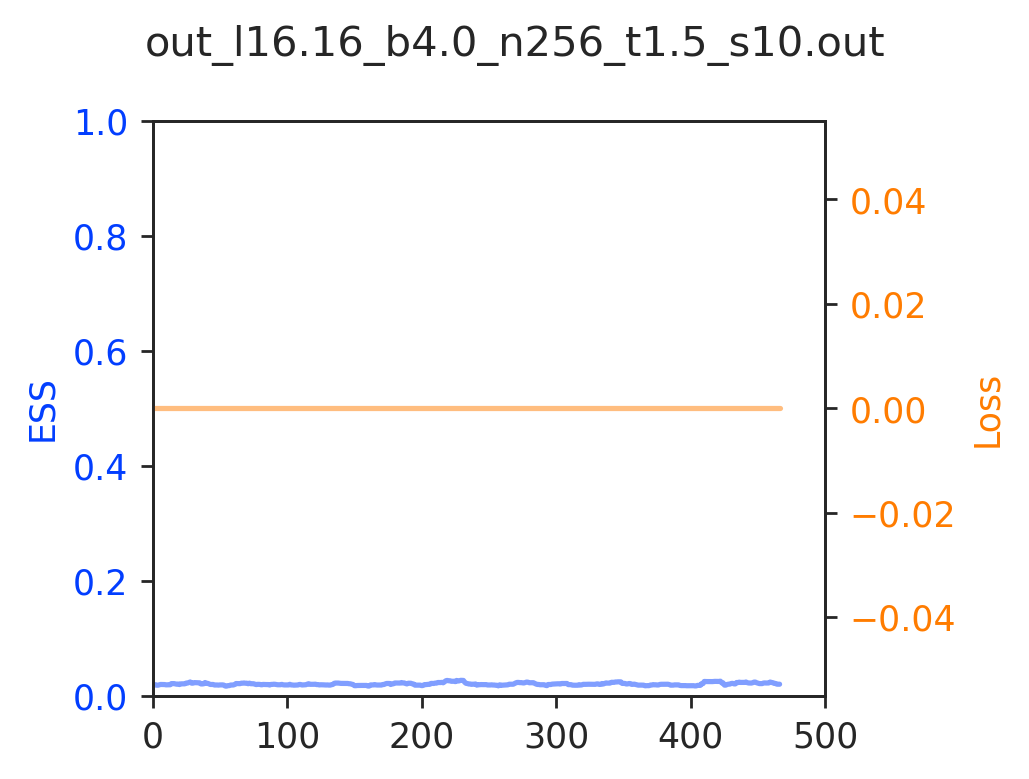

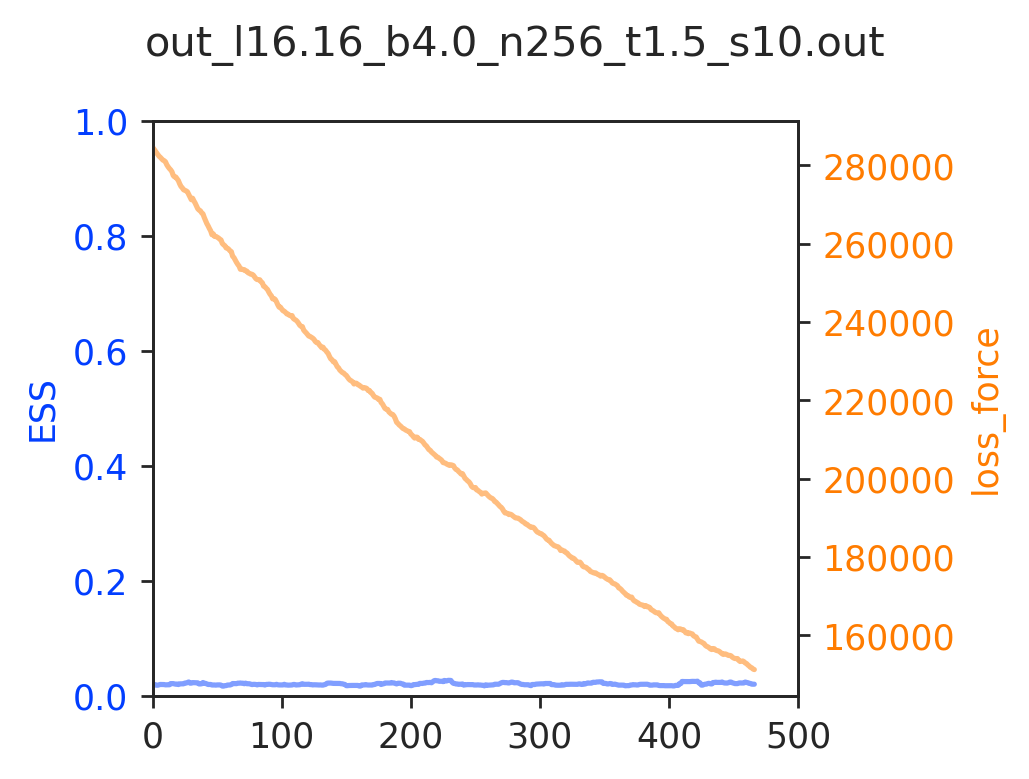

In [66]:
# flow_model_trained_force
#flow_model_tf, flow_act_tf = flow_train(param, n_era=5,
outputs = flow_train(param, n_era=5,
                     with_force=True,
                     pre_model=pre_flow_model)
flow_model_tf = outputs['model']
flow_model_history_tf = outputs['history']
flow_act_tf = outputs['action']

### Save the model trained with force:

In [68]:

model_dir = os.path.join(OUTDIR, 'flow_model_with_force')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
    
layers_file = os.path.join(model_dir, 'flow_model_with_force.pth')
console.log(f'Saving `flow_model_tf` to {layers_file}.')
torch.save(flow_model_tf['layers'].state_dict(), layers_file)

[00:44:38]  Saving `flow_model_tf` to /lus/grand/projects/DLHMC/nftqcd/fthmc/flow_test_sam/notebooks/outputs/2021-05-18/flow_model_with_force/flow_model_with_force.pth.

In [69]:
def test_force(
    param: Param,
    model: dict,
    x: torch.Tensor = None,
    pre_model: dict = None
):
    """Test the force."""
    if x is None:
        if pre_model is None:
            raise ValueError(f'Either `x` or `pre_model` must be specified.')
            
        pre_xi = pre_model['prior'].sample_n(1)
        x = qed.ft_flow(pre_model['layers'], pre_xi)
        
    xi = qed.ft_flow_inv(model['layers'], x)
    force = qed.ft_force(param, model['layers'], xi)
    force_norm = torch.linalg.norm(force)
    return force_norm

In [73]:
field_arr = torch.stack(tuple(fields.values()), dim=0)
logger.log(field_arr.shape)

[01:36:06]  torch.Size([4, 2, 16, 16])

In [80]:
#test_force(n=1)

for field in field_arr:
    force_tf = test_force(param, flow_model_tf, pre_model=pre_flow_model)
    console.log(f'ft_flow(players, pxi), (pxi ~ pre_prior): {force_tf:.5g}') 
    
    x = field[None, :]
    if torch.cuda.is_available():
        x = x.cuda()
    
    #x_ = field_arr.squeeze()[None, :]
    force_ = test_force(param, flow_model_tf, x=x, pre_model=pre_flow_model)
    console.log(f'ft_flow(layers, field_arr), (pxi ~ pre_prior): {force_:.5g}')

[01:39:17]  ft_flow(players, pxi), (pxi ~ pre_prior): 45.98

[01:39:18]  ft_flow(layers, field_arr), (pxi ~ pre_prior): 42.526

            ft_flow(players, pxi), (pxi ~ pre_prior): 49.148

            ft_flow(layers, field_arr), (pxi ~ pre_prior): 47.314

[01:39:19]  ft_flow(players, pxi), (pxi ~ pre_prior): 46.374

            ft_flow(layers, field_arr), (pxi ~ pre_prior): 44.477

[01:39:20]  ft_flow(players, pxi), (pxi ~ pre_prior): 47.645

            ft_flow(layers, field_arr), (pxi ~ pre_prior): 45.689

In [83]:
x = field_arr[-1][None, :]
if torch.cuda.is_available():
    x = x.cuda()
    
force1 = test_force(param, flow_model_tf, pre_model=pre_flow_model)
force2 = test_force(param, flow_model_tf, x=x)
                    #, x=field_arr[:2].squeeze()[None, :])

logger.log(f'force1: {force1}')
logger.log(f'force2: {force2}')

[01:41:28]  force1: 52.84053039550781

            force2: 45.688724517822266

In [77]:
#fields_ = torch.tensor([i for i in list(fields.values())])
fields_arr = torch.stack(tuple(fields.values()), dim=0)
#list(fields.values())[0]

In [85]:
field_arr.shape

torch.Size([4, 2, 16, 16])

In [91]:
#field_run = torch.stack(tuple(fields.values()), dim=0)
##flows = flow
x0 = field_arr[0][None, :]

x = field_arr[0][None, :]

if torch.cuda.is_available():
    x = x.cuda()

plaq0 = qed.action(param, x) / (-param.beta * param.volume)
logger.log(f'plaq(field_arr[0])={plaq0:.8g}')

#logger\.log(f'plaq(field_run[0]) {qed.action(param, x) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
#x = field_run[0][None, :]
logJ = 0.0
for layer in reversed(flow_model_tf['layers']):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flow_model_tf['layers']:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = qed.action(param, y[0][None, :]) - logJy

logger.log(f'sum(logJ): {qed.grab(logJ.sum())}')
logger.log(f'sum(logJy): {qed.grab(logJy.sum())}')
#print(logJ,logJy)


# print("eff_action", s + 136.3786)

logger.log(f'original_action: {qed.action(param, y[0][None, :]) + 91}')
#print("original_action", qed.action(param, y[0][None, :]) + 91)

logger.log(f'eff_action: {s + 56}')
#print("eff_action", {s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

logger.log(f'plaq(x) {qed.action(param, x[0][None, :]) / (-param.beta*param.volume)}  logJ {qed.grab(logJ)}  force.norm {torch.linalg.norm(f)}')
logger.log(f'plaq(y) {qed.action(param, y[0][None, :]) / (-param.beta*param.volume)}')
logger.log(f'plaq(x) {qed.action(param, x0) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(qed.force(param, x0))}')

[01:50:32]  plaq(field_arr[0])=0.8866145

tensor([[[[5.7870e+00, 4.1124e+00, 2.6104e+00, 5.9390e+00, 3.7640e+00,
           2.2530e+00, 5.0016e+00, 4.9244e+00, 5.5489e+00, 3.9502e+00,
           4.6706e+00, 1.0250e+00, 1.7602e+00, 3.2970e-01, 1.4977e+00,
           1.6383e+00],
          [4.3679e+00, 2.8816e+00, 5.0166e+00, 7.4766e-01, 2.8966e+00,
           5.6310e-01, 5.6294e+00, 4.4533e+00, 2.4277e+00, 1.5156e+00,
           4.5280e+00, 4.5266e+00, 4.1578e+00, 2.0063e+00, 1.4017e+00,
           5.7352e+00],
          [3.7428e+00, 4.0471e-01, 5.2393e+00, 3.6712e+00, 3.1940e+00,
           4.3686e+00, 1.4705e+00, 2.3253e+00, 2.9771e+00, 6.0521e+00,
           2.1959e+00, 5.7740e+00, 5.4285e+00, 1.5203e+00, 1.7721e+00,
           2.3074e+00],
          [3.6326e+00, 3.6252e+00, 5.3983e+00, 1.4485e+00, 1.6429e+00,
           9.0057e-01, 4.4522e+00, 3.6380e+00, 4.7627e+00, 1.1172e+00,
           1.6284e+00, 5.6242e+00, 5.6224e+00, 1.4686e+00, 6.1091e+00,
           2.2298e-01],
          [2.1871e+00, 5.8813e+00, 7.9806e-01, 3.395

[01:50:33]  sum(logJ): 52.693824768066406

            sum(logJy): -52.69382095336914

            original_action: -816.8929443359375

            eff_action: tensor([-799.1991], grad_fn=<AddBackward0>)

tensor([[[[5.7870e+00, 4.1124e+00, 2.6104e+00, 5.9390e+00, 3.7640e+00,
           2.2530e+00, 5.0016e+00, 4.9244e+00, 5.5489e+00, 3.9502e+00,
           4.6706e+00, 1.0250e+00, 1.7602e+00, 3.2970e-01, 1.4977e+00,
           1.6383e+00],
          [4.3679e+00, 2.8816e+00, 5.0166e+00, 7.4766e-01, 2.8966e+00,
           5.6310e-01, 5.6294e+00, 4.4533e+00, 2.4277e+00, 1.5156e+00,
           4.5280e+00, 4.5266e+00, 4.1578e+00, 2.0063e+00, 1.4017e+00,
           5.7352e+00],
          [3.7428e+00, 4.0471e-01, 5.2393e+00, 3.6712e+00, 3.1940e+00,
           4.3686e+00, 1.4705e+00, 2.3253e+00, 2.9771e+00, 6.0521e+00,
           2.1959e+00, 5.7740e+00, 5.4285e+00, 1.5203e+00, 1.7721e+00,
           2.3074e+00],
          [3.6326e+00, 3.6252e+00, 5.3983e+00, 1.4485e+00, 1.6429e+00,
           9.0057e-01, 4.4522e+00, 3.6380e+00, 4.7627e+00, 1.1172e+00,
           1.6284e+00, 5.6242e+00, 5.6224e+00, 1.4686e+00, 6.1091e+00,
           2.2298e-01],
          [2.1871e+00, 5.8813e+00, 7.9806e-01, 3.395

            plaq(x) 0.7769433259963989  logJ [52.693825]  force.norm 42.52583694458008

            plaq(y) 0.886614203453064

            plaq(x) 0.8866145014762878  force.norm 55.38248825073242

In [94]:
logger.log(x.shape)
x = qed.ft_flow_inv(flow, field_arr.cuda())
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(ff))
fff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(fff))

[01:52:47]  torch.Size([1, 2, 16, 16])

[01:52:49]  tensor(709.2982)

            tensor(709.2982)

In [96]:
x = qed.ft_flow_inv(flow, field_arr)
put(qed.grab(qed.ft_action(param, flow, x)))

[01:59:44]  [-632.75385 -641.91797 -627.6553  -633.00116]

In [97]:
def flattern(l):
    return [x for y in l for x in y]

def average(l):
    return sum(l) / len(l)

def sub_avg(l):
    avg = average(l)
    return np.array([x - avg for x in l])

In [184]:
#ft_hmc_info_list = []
ft_hmc_info = {
    'force_norm_rms': [],
    'ft_action_init': [],
    'ft_action_end': [],
    'momentum_norm_end': [],
}

def ft_leapfrog(param, flow, x, p):
    mom_norm = torch.sum(p*p)
    info_list = []
    dt = param.dt
    x_ = x + 0.5*dt*p
    f = qed.ft_force(param, flow, x_)
    p_ = p + (-dt)*f
    info = {
        'force_norm': [torch.linalg.norm(f).cpu().detach().numpy()],
        'ft_action': [qed.ft_action(param, flow, x_).cpu().detach().numpy()],
        'momentum_norm': [(torch.sum(p * p_) / torch.sqrt(mom_norm * torch.sum(p_ * p_))).cpu().detach().numpy()],
    }
    
    #info_list.append(info)
    for i in range(param.nstep-1):
        x_ = x_ + dt*p_
        f = qed.ft_force(param, flow, x_)
        info_ = {
            'force_norm': torch.linalg.norm(f).cpu().detach().numpy(),
            'ft_action': qed.ft_action(param, flow, x_).cpu().detach().numpy(),
            'momentum_norm': (torch.sum(p * p_) / torch.sqrt(mom_norm * torch.sum(p_ * p_))).cpu().detach().numpy(),
        }
        for key, val in info_.items():
            info[key].append(val)
            
        #info = np.array([torch.linalg.norm(f),
        #     qed.ft_action(param, flow, x_),
        #     torch.sum(p * p_) / torch.sqrt(mom_norm * torch.sum(p_ * p_))])
        
        p_ = p_ + (-dt)*f
    x_ = x_ + 0.5*dt*p_
    
    force_norm_arr = np.array(info['force_norm'])
    
    info_ = {
        'force_norm_rms': np.sqrt(average(force_norm_arr ** 2)),
        'ft_action_init': info['ft_action'][0],
        'ft_action_end': info['ft_action'][-1],
        'momentum_norm_end': info['momentum_norm'][-1],
    }
    
    logger.print_metrics(info_)
    for key, val in info_.items():
        ft_hmc_info[key].append(val)
        
    #info_ = [
    #    np.sqrt(average(info['force_norm'] ** 2)),
    #    (info['ft_action'][0], info['ft_action'][-1]),
    #    info['momentum_norm'][-1],
    #]
    #info_ = [
    #    np.sqrt(average([l[0] ** 2 for l in info_list])),
    #    (info_list[0][1], info_list[-1][1]),
    #    info_list[-1][2]
    #]
    #put(', '.join([f'{i}' for i in info_]))
        
    #ft_hmc_info_list.append(info_list)
    return (x_, p_)

def ft_hmc(param, flow, field):
    x = qed.ft_flow_inv(flow, field)
    p = torch.randn_like(x)
    act0 = qed.ft_action(param, flow, x).cpu() + 0.5*torch.sum(p*p).cpu()
    x_, p_ = ft_leapfrog(param, flow, x, p)
    xr = qed.regularize(x_)
    act = qed.ft_action(param, flow, xr).cpu() + 0.5*torch.sum(p_*p_).cpu()
    prob = torch.rand([], dtype=torch.float64).cpu()
    dH = act - act0
    exp_mdH = torch.exp(-dH)
    acc = prob < exp_mdH
    # ADJUST ME
    newx = xr if acc else x
    # newx = xr
    newfield = qed.ft_flow(flow, newx)
    return (float(dH), float(exp_mdH), acc, newfield)

In [159]:
def ft_run(param, flow, field = None):
    if field == None:
        field = param.initializer()
    ft_hmc_info_list = []
    with open(param.uniquestr(), "w") as f:
        #params = param.summary()
        f.write(repr(param))
        logger.log(repr(param))
        #put(params)
        plaq = qed.action(param, torch.squeeze(field)) / (-param.beta*param.volume)
        topo = qed.topo_charge(torch.squeeze(field)[None, :])
        #plaq, topo = (qed.action(param, field[None, :]) / (-param.beta*param.volume), qed.topo_charge(field[None, :]))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        f.write(status)
        logger.log(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                #field_run = torch.reshape(field,(1,)+field.shape)
#                 
                dH, exp_mdH, acc, field = ft_hmc(param, flow, torch.squeeze(field)[None, :])
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                topo = qed.topo_charge(torch.squeeze(field)[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                metrics = {
                    'traj': n * param.ntraj + i + 1 + 4,
                    'accept': acc,
                    'dH': dH,
                    'expdH': exp_mdH,
                    'plaq': plaq,
                    'topo': topo,
                }
                #status = {
                #    'traj': f'{n * param.ntraj+i+1:4}',
                #    'accept': f'{qed.grab(acc)[0]}',
                #    'dH': f'{dH:< 12.8}',
                #    'expdH': f'{exp_mdH:< 12.8}',
                #    'plaq': f'{plaq:< 12.8}',
                #    'topo': f'{qed.grab(topo)[0]:< 3.3}',
                #}
                #status = io.print_metrics(status)
                #outstr = ', '.join(
                #    '='.join((k, v)) for k, v in status.items()
                #)
                #f.write(status + '\n')
                
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    outstr = io.print_metrics(metrics)
                    f.write(outstr + '\n')
                    
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
    return field

In [186]:
def ft_run(param, flow, field = None):
    if field == None:
        field = param.initializer()
    ft_hmc_info_list = []
    with open(param.uniquestr(), "w") as f:
        f.write(repr(param))
        logger.log(repr(param))
        plaq = qed.action(param, torch.squeeze(field)) / (-param.beta*param.volume)
        topo = qed.topo_charge(torch.squeeze(field)[None, :])
        #plaq, topo = (qed.action(param, field[None, :]) / (-param.beta*param.volume), qed.topo_charge(field[None, :]))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        f.write(status)
        put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                #field_run = torch.reshape(field,(1,)+field.shape)
                
                dH, exp_mdH, acc, field = ft_hmc(param, flow, torch.squeeze(field)[None, :])
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                topo = qed.topo_charge(torch.squeeze(field)[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                status = {
                    'traj': f'{n * param.ntraj+i+1:4}',
                    'accept': f'{qed.grab(acc)[0]}',
                    'dH': f'{dH:< 12.8}',
                    'expdH': f'{exp_mdH:< 12.8}',
                    'plaq': f'{plaq:< 12.8}',
                    'topo': f'{qed.grab(topo)[0]:< 3.3}',
                }
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    outstr = logger.print_metrics(status)
                    f.write(outstr + '\n')
                    
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
    return field

## Run field transformation (with force) using `pre_flow_model`


In [194]:
param.nprint = 256

field_ = ft_run(param, pre_flow_model['layers'], field=field_arr[-1])#, torch.stack(tuple(field.values()), dim=0).squeeze())

[04:24:14]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=256                                                                                                                                                                                                                       
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

[04:24:14]  Initial configuration:  plaq: 0.869631826877594  topo: tensor([1.0000], device='cpu')

[04:24:16]  force_norm_rms=677   ft_action_init=-612.6 ft_action_end=-598.5 momentum_norm_end=0.1869

            traj=   1  accept=False dH= 49677.527   expdH= 0.0         plaq= 0.86963183  topo= 1.0

[04:24:18]  force_norm_rms=454.4 ft_action_init=-621.9 ft_action_end=-615.1 momentum_norm_end=0.1072

            traj=   2  accept=False dH= 24183.988   expdH= 0.0         plaq= 0.86963201  topo= 1.0

[04:24:20]  force_norm_rms=548   ft_action_init=-617.8 ft_action_end=-605.7 momentum_norm_end=0.07514

            traj=   3  accept=False dH= 37598.027   expdH= 0.0         plaq= 0.86963189  topo= 1.0

[04:24:22]  force_norm_rms=387.3 ft_action_init=-619.1 ft_action_end=-600.6 momentum_norm_end=0.1566

            traj=   4  accept=False dH= 18681.699   expdH= 0.0         plaq= 0.86963171  topo= 1.0

[04:24:24]  force_norm_rms=438.2 ft_action_init=-616  ft_action_end=-604.8 momentum_norm_end=0.09803

            traj=   5  accept=False dH= 20619.186   expdH= 0.0         plaq= 0.86963177  topo= 1.0

[04:24:26]  force_norm_rms=3243  ft_action_init=-619.4 ft_action_end=-613.8 momentum_norm_end=0.1376

            traj=   6  accept=False dH= 1177293.0   expdH= 0.0         plaq= 0.86963159  topo= 1.0

[04:24:28]  force_norm_rms=258.7 ft_action_init=-623.4 ft_action_end=-602.7 momentum_norm_end=0.1268

            traj=   7  accept=False dH= 6878.2363   expdH= 0.0         plaq= 0.86963141  topo= 1.0

[04:24:29]  force_norm_rms=654   ft_action_init=-612.1 ft_action_end=-609.2 momentum_norm_end=0.09305

[04:24:30]  traj=   8  accept=False dH= 48466.75    expdH= 0.0         plaq= 0.86963141  topo= 1.0

[04:24:31]  force_norm_rms=400   ft_action_init=-622.7 ft_action_end=-601.6 momentum_norm_end=0.09177

            traj=   9  accept=False dH= 19732.51    expdH= 0.0         plaq= 0.86963111  topo= 1.0

[04:24:33]  force_norm_rms=464   ft_action_init=-619.6 ft_action_end=-607.6 momentum_norm_end=0.05522

            traj=  10  accept=False dH= 24130.795   expdH= 0.0         plaq= 0.86963105  topo= 1.0

[04:24:35]  force_norm_rms=403.5 ft_action_init=-624.7 ft_action_end=-597.9 momentum_norm_end=0.1282

            traj=  11  accept=False dH= 20860.229   expdH= 0.0         plaq= 0.86963099  topo= 1.0

[04:24:37]  force_norm_rms=525.4 ft_action_init=-616.3 ft_action_end=-612.8 momentum_norm_end=0.1295

            traj=  12  accept=False dH= 32495.359   expdH= 0.0         plaq= 0.86963093  topo= 1.0

[04:24:39]  force_norm_rms=387.4 ft_action_init=-621.2 ft_action_end=-591.1 momentum_norm_end=0.09031

            traj=  13  accept=False dH= 16452.723   expdH= 0.0         plaq= 0.86963075  topo= 1.0

[04:24:41]  force_norm_rms=486.5 ft_action_init=-608.9 ft_action_end=-607.9 momentum_norm_end=0.01259

            traj=  14  accept=False dH= 27294.906   expdH= 0.0         plaq= 0.86963046  topo= 1.0

KeyboardInterrupt: 

In [193]:
param0.nprint

256

In [190]:
param0 = Param(
    beta=2.0,
    L=16,
    tau=1., # 0.3
    nstep=10, # 3
    nrun=4,
    # ADJUST ME
    ntraj=256, # 2**16 # 2**10 # 2**15
    #nprint=1,
    seed=1331,
)

logger.log(repr(param0))

# field = ft_run(param, pre_flow)
field0 = ft_run(param0, pre_flow_model['layers'])#, torch.stack(tuple(field.values()), dim=0).squeeze())

[04:22:20]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=2.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.0                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=256                                                                                                                                                                                                                       
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

            Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=2.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.0                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=256                                                                                                                                                                                                                       
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

[04:22:20]  Initial configuration:  plaq: 1.0  topo: tensor([0.])

[04:22:22]  force_norm_rms=71.9  ft_action_init=-124.3 ft_action_end=-176.6 momentum_norm_end=0.7867

            traj=   1  accept=False dH= 381.63507   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:22:24]  force_norm_rms=70.05 ft_action_init=-123.7 ft_action_end=-169.1 momentum_norm_end=0.7641

            traj=   2  accept=False dH= 175.40977   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:22:26]  force_norm_rms=89.78 ft_action_init=-123.8 ft_action_end=-179.8 momentum_norm_end=0.7148

            traj=   3  accept=False dH= 439.14038   expdH= 0.0         plaq= 1.0         topo=-1.82e-06

[04:22:27]  force_norm_rms=80.34 ft_action_init=-123.7 ft_action_end=-171.8 momentum_norm_end=0.8126

[04:22:28]  traj=   4  accept=False dH= 274.91846   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:22:29]  force_norm_rms=208.8 ft_action_init=-123.6 ft_action_end=-166.6 momentum_norm_end=0.8185

            traj=   5  accept=False dH= 2333.7749   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:22:31]  force_norm_rms=170.6 ft_action_init=-124  ft_action_end=-167.7 momentum_norm_end=0.4148

            traj=   6  accept=False dH= 1402.7661   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:22:33]  force_norm_rms=108.1 ft_action_init=-123.6 ft_action_end=-174.6 momentum_norm_end=0.7004

            traj=   7  accept=False dH= 585.13727   expdH= 0.0         plaq= 1.0         topo= 6.07e-07

[04:22:35]  force_norm_rms=154.7 ft_action_init=-123.9 ft_action_end=-171.7 momentum_norm_end=0.7767

            traj=   8  accept=False dH= 1165.7595   expdH= 0.0         plaq= 1.0         topo= 2.43e-06

[04:22:37]  force_norm_rms=80.23 ft_action_init=-123.6 ft_action_end=-163.8 momentum_norm_end=0.8029

            traj=   9  accept=False dH= 298.17453   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:22:38]  force_norm_rms=121.7 ft_action_init=-123.6 ft_action_end=-168.5 momentum_norm_end=0.4866

            traj=  10  accept=False dH= 755.71008   expdH= 0.0         plaq= 1.0         topo= 0.0

[04:22:40]  force_norm_rms=117   ft_action_init=-124  ft_action_end=-168.5 momentum_norm_end=0.6487

            traj=  11  accept=False dH= 876.25781   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:22:42]  force_norm_rms=122.1 ft_action_init=-123.4 ft_action_end=-176.1 momentum_norm_end=0.8023

            traj=  12  accept=False dH= 683.95679   expdH= 0.0         plaq= 1.0         topo= 6.07e-07

[04:22:44]  force_norm_rms=64.1  ft_action_init=-124.1 ft_action_end=-171.3 momentum_norm_end=0.8155

            traj=  13  accept=False dH= 250.32959   expdH= 0.0         plaq= 1.0         topo= 0.0

[04:22:46]  force_norm_rms=179.6 ft_action_init=-123.7 ft_action_end=-178.9 momentum_norm_end=0.3808

            traj=  14  accept=False dH= 1485.4014   expdH= 0.0         plaq= 1.0         topo= 1.21e-06

KeyboardInterrupt: 

In [183]:
%debug

> <ipython-input-181-5daca6c06285>(79)ft_hmc()
     77     dH = act - act0
     78     exp_mdH = torch.exp(-dH)
---> 79     acc = prob < exp_mdH
     80     # ADJUST ME
     81     newx = xr if acc else x

ipdb> prob
tensor(0.7687, dtype=torch.float64)
ipdb> exp_mdH
tensor([0.], device='cpu', grad_fn=<ExpBackward>)
ipdb> acc = prob.cpu() < exp_mdH
ipdb> acc
tensor([False], device='cpu')
ipdb> q


In [ ]:
import train as test

# pre_flow = pre_flow_model['layers']
fields, metrics = test.ft_run(param0,
                              flow=pre_flow,
                              logger=logger)

In [196]:
# param = Param(
#    beta = 2.0,
#    lat = (8, 8),
#    tau = 0.5, # 0.3
#    nstep = 64, # 3
#    # ADJUST ME
#    ntraj = 4, # 2**16 # 2**10 # 2**15
#    nprint = 4,
#    #
#    seed = 1331)

# field = ft_run(param, pre_flow)
#field_tf = ft_run(param, flow_model_tf['layers'])#, torch.stack(tuple(field.values()), dim=0).squeeze())
field_tf = ft_run(param, flow_model_tf['layers'], field_arr[-1])#, torch.stack(tuple(field.values()), dim=0).squeeze())

[04:25:54]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=256                                                                                                                                                                                                                       
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

[04:25:54]  Initial configuration:  plaq: 0.869631826877594  topo: tensor([1.0000], device='cpu')

[04:25:56]  force_norm_rms=49.92 ft_action_init=-828.1 ft_action_end=-825.1 momentum_norm_end=0.3172

            traj=   1  accept=True  dH=-0.39758301  expdH= 1.4882233   plaq= 0.86856496  topo= 1.0

[04:25:58]  force_norm_rms=48.3  ft_action_init=-830.6 ft_action_end=-814.8 momentum_norm_end=0.3188

            traj=   2  accept=True  dH=-0.612854    expdH= 1.8456914   plaq= 0.85215837  topo= 1.0

[04:26:00]  force_norm_rms=50.13 ft_action_init=-815.3 ft_action_end=-833.6 momentum_norm_end=0.2005

            traj=   3  accept=True  dH= 1.1387329   expdH= 0.32022452  plaq= 0.87275726  topo= 1.0

[04:26:01]  force_norm_rms=46.75 ft_action_init=-831.6 ft_action_end=-825  momentum_norm_end=0.3688

[04:26:02]  traj=   4  accept=True  dH=-0.20825195  expdH= 1.2315234   plaq= 0.86578143  topo=-2.28e-07

[04:26:03]  force_norm_rms=45.88 ft_action_init=-824.6 ft_action_end=-832.6 momentum_norm_end=0.4004

            traj=   5  accept=True  dH= 0.47998047  expdH= 0.61879545  plaq= 0.8735714   topo= 0.0

[04:26:05]  force_norm_rms=45.2  ft_action_init=-841.8 ft_action_end=-832.5 momentum_norm_end=0.3081

            traj=   6  accept=True  dH=-0.82946777  expdH= 2.2920985   plaq= 0.86460567  topo= 9.11e-07

[04:26:07]  force_norm_rms=47.23 ft_action_init=-827.7 ft_action_end=-834.4 momentum_norm_end=0.3719

            traj=   7  accept=False dH= 1.006958    expdH= 0.36532861  plaq= 0.86460537  topo= 4.17e-07

[04:26:09]  force_norm_rms=46.44 ft_action_init=-827.8 ft_action_end=-840.7 momentum_norm_end=0.3192

            traj=   8  accept=True  dH= 0.84777832  expdH= 0.42836556  plaq= 0.87868381  topo= 6.83e-07

[04:26:11]  force_norm_rms=45.4  ft_action_init=-846.7 ft_action_end=-830.2 momentum_norm_end=0.2231

            traj=   9  accept=True  dH=-0.30596924  expdH= 1.3579406   plaq= 0.86354661  topo= 6.07e-07

[04:26:13]  force_norm_rms=46.75 ft_action_init=-826.9 ft_action_end=-839.7 momentum_norm_end=0.2359

            traj=  10  accept=True  dH= 0.011352539 expdH= 0.98871166  plaq= 0.87485063  topo=-4.55e-07

[04:26:14]  force_norm_rms=47.34 ft_action_init=-838.1 ft_action_end=-820.4 momentum_norm_end=0.291

[04:26:15]  traj=  11  accept=True  dH=-0.46716309  expdH= 1.5954616   plaq= 0.86326492  topo= 5.69e-07

[04:26:16]  force_norm_rms=47.99 ft_action_init=-823.6 ft_action_end=-823.5 momentum_norm_end=0.2955

            traj=  12  accept=False dH= 0.57373047  expdH= 0.5634197   plaq= 0.86326462  topo= 7.59e-07

[04:26:18]  force_norm_rms=45.99 ft_action_init=-828.4 ft_action_end=-833.9 momentum_norm_end=0.2236

            traj=  13  accept=True  dH= 0.47161865  expdH= 0.62399143  plaq= 0.86887956  topo= 1.25e-06

[04:26:20]  force_norm_rms=46.18 ft_action_init=-833.9 ft_action_end=-823.2 momentum_norm_end=0.3142

            traj=  14  accept=True  dH=-0.5246582   expdH= 1.6898812   plaq= 0.86243099  topo=-3.79e-08

[04:26:22]  force_norm_rms=46.78 ft_action_init=-825.6 ft_action_end=-832  momentum_norm_end=0.2818

            traj=  15  accept=False dH= 0.23602295  expdH= 0.78976256  plaq= 0.86243063  topo= 4.93e-07

[04:26:24]  force_norm_rms=47.59 ft_action_init=-818.2 ft_action_end=-832.6 momentum_norm_end=0.3271

            traj=  16  accept=False dH= 0.3237915   expdH= 0.72340107  plaq= 0.86243027  topo=-1.9e-07

[04:26:26]  force_norm_rms=49.36 ft_action_init=-821.8 ft_action_end=-825.9 momentum_norm_end=0.3807

            traj=  17  accept=True  dH= 0.071228027 expdH= 0.9312495   plaq= 0.86624968  topo= 3.79e-07

[04:26:27]  force_norm_rms=47.19 ft_action_init=-833.9 ft_action_end=-830.1 momentum_norm_end=0.224

[04:26:28]  traj=  18  accept=True  dH=-0.29449463  expdH= 1.3424478   plaq= 0.86123896  topo= 3.04e-07

[04:26:29]  force_norm_rms=47.54 ft_action_init=-824  ft_action_end=-829.1 momentum_norm_end=0.3657

            traj=  19  accept=True  dH= 0.27593994  expdH= 0.7588585   plaq= 0.87049735  topo= 1.1e-06

[04:26:31]  force_norm_rms=46.97 ft_action_init=-830.6 ft_action_end=-833.6 momentum_norm_end=0.3436

            traj=  20  accept=True  dH= 0.26568604  expdH= 0.76667982  plaq= 0.87246299  topo=-6.45e-07

[04:26:33]  force_norm_rms=46.32 ft_action_init=-837.7 ft_action_end=-839.7 momentum_norm_end=0.3128

            traj=  21  accept=True  dH= 0.0039672852 expdH= 0.99604058  plaq= 0.87283468  topo=-2.0

[04:26:35]  force_norm_rms=47.33 ft_action_init=-840.2 ft_action_end=-816.1 momentum_norm_end=0.3333

            traj=  22  accept=True  dH=-0.51568604  expdH= 1.674787    plaq= 0.8529337   topo=-2.0

[04:26:37]  force_norm_rms=47.65 ft_action_init=-817.1 ft_action_end=-830.3 momentum_norm_end=0.3472

            traj=  23  accept=False dH= 0.67053223  expdH= 0.51143628  plaq= 0.85293341  topo=-2.0

[04:26:39]  force_norm_rms=49.02 ft_action_init=-813.9 ft_action_end=-814.2 momentum_norm_end=0.3016

            traj=  24  accept=True  dH= 0.02734375  expdH= 0.97302669  plaq= 0.84948027  topo=-2.0

[04:26:41]  force_norm_rms=48.71 ft_action_init=-815.2 ft_action_end=-813.2 momentum_norm_end=0.2692

            traj=  25  accept=True  dH=-0.19482422  expdH= 1.2150974   plaq= 0.84814483  topo=-2.0

[04:26:42]  force_norm_rms=48.04 ft_action_init=-808.5 ft_action_end=-821.8 momentum_norm_end=0.2959

            traj=  26  accept=True  dH= 0.67059326  expdH= 0.51140511  plaq= 0.85891807  topo=-2.0

[04:26:44]  force_norm_rms=46.49 ft_action_init=-823.1 ft_action_end=-821.9 momentum_norm_end=0.336

            traj=  27  accept=True  dH=-0.39367676  expdH= 1.4824213   plaq= 0.85707176  topo=-2.0

[04:26:46]  force_norm_rms=47.44 ft_action_init=-817.6 ft_action_end=-831.5 momentum_norm_end=0.2795

            traj=  28  accept=True  dH= 0.48120117  expdH= 0.61804056  plaq= 0.86948025  topo=-2.0

[04:26:48]  force_norm_rms=48.32 ft_action_init=-835  ft_action_end=-828.9 momentum_norm_end=0.2839

            traj=  29  accept=True  dH=-0.17260742  expdH= 1.1883994   plaq= 0.86782026  topo=-2.0

[04:26:50]  force_norm_rms=47.8  ft_action_init=-831.2 ft_action_end=-831.8 momentum_norm_end=0.3215

            traj=  30  accept=True  dH= 0.38873291  expdH= 0.67791533  plaq= 0.87145317  topo=-2.0

[04:26:52]  force_norm_rms=46.91 ft_action_init=-836.5 ft_action_end=-834.1 momentum_norm_end=0.3229

            traj=  31  accept=True  dH=-0.13885498  expdH= 1.1489575   plaq= 0.87095058  topo=-2.0

[04:26:54]  force_norm_rms=44.17 ft_action_init=-835.8 ft_action_end=-853.4 momentum_norm_end=0.2828

            traj=  32  accept=False dH= 1.0358887   expdH= 0.35491085  plaq= 0.87095028  topo=-2.0

[04:26:55]  force_norm_rms=46.3  ft_action_init=-833.2 ft_action_end=-835.4 momentum_norm_end=0.224

            traj=  33  accept=True  dH= 0.4901123   expdH= 0.61255759  plaq= 0.87353957  topo=-2.0

[04:26:57]  force_norm_rms=44.31 ft_action_init=-836.8 ft_action_end=-837.9 momentum_norm_end=0.3019

            traj=  34  accept=True  dH=-0.28070068  expdH= 1.3240572   plaq= 0.87142348  topo=-2.0

[04:26:59]  force_norm_rms=45.3  ft_action_init=-836.8 ft_action_end=-846.7 momentum_norm_end=0.2609

            traj=  35  accept=True  dH= 0.21539307  expdH= 0.80622447  plaq= 0.88323665  topo=-2.0

[04:27:01]  force_norm_rms=46.58 ft_action_init=-843.3 ft_action_end=-843.7 momentum_norm_end=0.3321

            traj=  36  accept=True  dH=-0.22406006  expdH= 1.2511462   plaq= 0.88709742  topo=-2.0

[04:27:03]  force_norm_rms=46.12 ft_action_init=-855  ft_action_end=-829.9 momentum_norm_end=0.2699

            traj=  37  accept=True  dH=-0.61065674  expdH= 1.8416405   plaq= 0.86823589  topo=-2.0

[04:27:05]  force_norm_rms=49.04 ft_action_init=-831.1 ft_action_end=-823.3 momentum_norm_end=0.2656

            traj=  38  accept=True  dH= 0.10266113  expdH= 0.90243274  plaq= 0.86130077  topo=-2.0

[04:27:07]  force_norm_rms=47.77 ft_action_init=-824.6 ft_action_end=-834.3 momentum_norm_end=0.312

            traj=  39  accept=True  dH= 0.31719971  expdH= 0.7281853   plaq= 0.86977863  topo=-3.0

[04:27:08]  force_norm_rms=45.72 ft_action_init=-833.4 ft_action_end=-853.9 momentum_norm_end=0.2274

            traj=  40  accept=True  dH= 0.75048828  expdH= 0.47213596  plaq= 0.88359964  topo=-3.0

[04:27:10]  force_norm_rms=46.25 ft_action_init=-843.4 ft_action_end=-831  momentum_norm_end=0.1947

            traj=  41  accept=True  dH=-0.94836426  expdH= 2.5814836   plaq= 0.86562896  topo=-3.0

[04:27:12]  force_norm_rms=46.34 ft_action_init=-834.7 ft_action_end=-840.3 momentum_norm_end=0.2908

            traj=  42  accept=True  dH=-0.25439453  expdH= 1.2896805   plaq= 0.87539166  topo=-3.0

[04:27:14]  force_norm_rms=46.25 ft_action_init=-839.9 ft_action_end=-834.3 momentum_norm_end=0.3699

            traj=  43  accept=True  dH= 0.19293213  expdH= 0.82453793  plaq= 0.87245208  topo=-3.0

[04:27:16]  force_norm_rms=45.3  ft_action_init=-838.8 ft_action_end=-850  momentum_norm_end=0.2211

            traj=  44  accept=False dH= 0.79748535  expdH= 0.45046028  plaq= 0.87245166  topo=-3.0

[04:27:18]  force_norm_rms=46.91 ft_action_init=-838  ft_action_end=-835.7 momentum_norm_end=0.1307

            traj=  45  accept=True  dH=-0.96685791  expdH= 2.6296687   plaq= 0.85684586  topo=-3.0

[04:27:20]  force_norm_rms=49.48 ft_action_init=-827.1 ft_action_end=-811.8 momentum_norm_end=0.2816

            traj=  46  accept=True  dH=-0.17419434  expdH= 1.1902869   plaq= 0.85090482  topo=-3.0

[04:27:21]  force_norm_rms=49.04 ft_action_init=-813  ft_action_end=-833.3 momentum_norm_end=0.3632

            traj=  47  accept=False dH= 1.3875732   expdH= 0.24968049  plaq= 0.85090441  topo=-3.0

[04:27:23]  force_norm_rms=49.46 ft_action_init=-812.9 ft_action_end=-825.6 momentum_norm_end=0.4238

            traj=  48  accept=False dH= 0.93145752  expdH= 0.39397907  plaq= 0.85090411  topo=-3.0

[04:27:25]  force_norm_rms=48.75 ft_action_init=-813.7 ft_action_end=-827.9 momentum_norm_end=0.2533

            traj=  49  accept=True  dH= 0.73980713  expdH= 0.47720593  plaq= 0.86427474  topo=-2.0

[04:27:27]  force_norm_rms=50.78 ft_action_init=-828.9 ft_action_end=-813.7 momentum_norm_end=0.27

            traj=  50  accept=True  dH=-1.0670776   expdH= 2.906872    plaq= 0.85194552  topo=-2.0

[04:27:29]  force_norm_rms=50.78 ft_action_init=-817.1 ft_action_end=-794.6 momentum_norm_end=0.2149

            traj=  51  accept=True  dH=-0.65087891  expdH= 1.9172251   plaq= 0.8256892   topo=-2.0

[04:27:30]  force_norm_rms=50.29 ft_action_init=-791.9 ft_action_end=-815.4 momentum_norm_end=0.2698

[04:27:31]  traj=  52  accept=False dH= 1.0342407   expdH= 0.3554962   plaq= 0.82568896  topo=-2.0

[04:27:32]  force_norm_rms=50.26 ft_action_init=-793.1 ft_action_end=-816.4 momentum_norm_end=0.1941

            traj=  53  accept=False dH= 1.4051514   expdH= 0.24532992  plaq= 0.8256886   topo=-2.0

[04:27:34]  force_norm_rms=51.18 ft_action_init=-783.4 ft_action_end=-830.6 momentum_norm_end=0.3559

            traj=  54  accept=False dH= 2.190918    expdH= 0.11181406  plaq= 0.82568824  topo=-2.0

[04:27:36]  force_norm_rms=49.42 ft_action_init=-792.8 ft_action_end=-823.2 momentum_norm_end=0.2032

            traj=  55  accept=False dH= 1.1972656   expdH= 0.30201891  plaq= 0.825688    topo=-2.0

[04:27:38]  force_norm_rms=51.02 ft_action_init=-788.7 ft_action_end=-824.6 momentum_norm_end=0.3129

            traj=  56  accept=True  dH= 1.2507324   expdH= 0.28629503  plaq= 0.8598969   topo=-1.0

[04:27:40]  force_norm_rms=50.17 ft_action_init=-821.2 ft_action_end=-817  momentum_norm_end=0.264

            traj=  57  accept=True  dH=-0.39593506  expdH= 1.4857728   plaq= 0.85608697  topo=-1.0

[04:27:41]  force_norm_rms=48.21 ft_action_init=-823.5 ft_action_end=-833.5 momentum_norm_end=0.2582

            traj=  58  accept=True  dH= 0.78894043  expdH= 0.45432594  plaq= 0.86127788  topo=-1.0

[04:27:43]  force_norm_rms=45.7  ft_action_init=-833.5 ft_action_end=-848.3 momentum_norm_end=0.2758

            traj=  59  accept=False dH= 0.51617432  expdH= 0.59679937  plaq= 0.86127752  topo=-1.0

[04:27:45]  force_norm_rms=48.49 ft_action_init=-822.3 ft_action_end=-818.4 momentum_norm_end=0.3107

            traj=  60  accept=True  dH=-0.18945312  expdH= 1.2085885   plaq= 0.85526168  topo=-1.0

[04:27:47]  force_norm_rms=48.27 ft_action_init=-819.7 ft_action_end=-818.6 momentum_norm_end=0.2689

            traj=  61  accept=True  dH= 0.14520264  expdH= 0.864847    plaq= 0.85480273  topo= 3.42e-07

[04:27:49]  force_norm_rms=47.72 ft_action_init=-813.4 ft_action_end=-817.4 momentum_norm_end=0.3098

            traj=  62  accept=True  dH=-0.053649902 expdH= 1.0551151   plaq= 0.85559845  topo=-1.0

[04:27:50]  force_norm_rms=48.19 ft_action_init=-826.7 ft_action_end=-812.4 momentum_norm_end=0.3152

[04:27:51]  traj=  63  accept=True  dH=-0.60943604  expdH= 1.8393937   plaq= 0.8531782   topo=-2.0

[04:27:52]  force_norm_rms=51.52 ft_action_init=-817.7 ft_action_end=-807.8 momentum_norm_end=0.286

            traj=  64  accept=True  dH=-0.081481934 expdH= 1.0848936   plaq= 0.84945005  topo=-2.0

[04:27:54]  force_norm_rms=51.15 ft_action_init=-805.5 ft_action_end=-830.5 momentum_norm_end=0.3133

            traj=  65  accept=True  dH= 0.10449219  expdH= 0.90078181  plaq= 0.86399299  topo=-2.0

[04:27:56]  force_norm_rms=45.31 ft_action_init=-829.5 ft_action_end=-853.6 momentum_norm_end=0.3188

            traj=  66  accept=False dH= 1.7462158   expdH= 0.17443278  plaq= 0.86399269  topo=-2.0

[04:27:58]  force_norm_rms=49.39 ft_action_init=-826.5 ft_action_end=-823.6 momentum_norm_end=0.2215

            traj=  67  accept=True  dH= 0.24700928  expdH= 0.78113347  plaq= 0.85893059  topo=-2.0

[04:28:00]  force_norm_rms=46.97 ft_action_init=-825.6 ft_action_end=-829.3 momentum_norm_end=0.2358

            traj=  68  accept=True  dH= 0.36907959  expdH= 0.69137037  plaq= 0.85679501  topo=-1.0

[04:28:01]  force_norm_rms=48.63 ft_action_init=-818.9 ft_action_end=-808.6 momentum_norm_end=0.2622

[04:28:02]  traj=  69  accept=True  dH=-0.91540527  expdH= 2.4977872   plaq= 0.84128368  topo=-4.55e-07

[04:28:03]  force_norm_rms=49.34 ft_action_init=-805.8 ft_action_end=-821.6 momentum_norm_end=0.2949

            traj=  70  accept=True  dH= 0.70947266  expdH= 0.49190354  plaq= 0.85873401  topo=-4.17e-07

[04:28:05]  force_norm_rms=47.15 ft_action_init=-827.7 ft_action_end=-828.2 momentum_norm_end=0.2437

            traj=  71  accept=False dH= 0.46777344  expdH= 0.6263954   plaq= 0.85873377  topo=-3.04e-07

[04:28:07]  force_norm_rms=46.47 ft_action_init=-823.7 ft_action_end=-846.2 momentum_norm_end=0.377

            traj=  72  accept=False dH= 1.8963623   expdH= 0.1501137   plaq= 0.85873348  topo= 0.0

[04:28:09]  force_norm_rms=47.99 ft_action_init=-819.2 ft_action_end=-831.2 momentum_norm_end=0.4052

            traj=  73  accept=False dH= 0.55584717  expdH= 0.57358611  plaq= 0.85873318  topo=-5.69e-07

[04:28:11]  force_norm_rms=45.44 ft_action_init=-827.8 ft_action_end=-835.5 momentum_norm_end=0.3425

            traj=  74  accept=True  dH= 1.2324829   expdH= 0.29156774  plaq= 0.8688789   topo=-3.79e-07

[04:28:12]  force_norm_rms=48.9  ft_action_init=-830.5 ft_action_end=-805.8 momentum_norm_end=0.2541

            traj=  75  accept=True  dH=-2.1026001   expdH= 8.1874304   plaq= 0.84293866  topo=-1.52e-07

[04:28:14]  force_norm_rms=51.08 ft_action_init=-805.6 ft_action_end=-815.4 momentum_norm_end=0.2588

            traj=  76  accept=True  dH=-0.31109619  expdH= 1.3649205   plaq= 0.85048199  topo=-2.28e-07

[04:28:16]  force_norm_rms=51.08 ft_action_init=-808.6 ft_action_end=-825.5 momentum_norm_end=0.3287

            traj=  77  accept=False dH= 1.0874634   expdH= 0.33707044  plaq= 0.85048175  topo= 2.28e-07

[04:28:18]  force_norm_rms=49.01 ft_action_init=-810.1 ft_action_end=-836.5 momentum_norm_end=0.3066

            traj=  78  accept=False dH= 2.0505981   expdH= 0.12865792  plaq= 0.85048139  topo=-6.07e-07

[04:28:20]  force_norm_rms=48.95 ft_action_init=-821.2 ft_action_end=-831.5 momentum_norm_end=0.3955

            traj=  79  accept=False dH= 1.7758789   expdH= 0.16933456  plaq= 0.85048109  topo=-4.55e-07

[04:28:21]  force_norm_rms=50.51 ft_action_init=-811.9 ft_action_end=-822.7 momentum_norm_end=0.2819

[04:28:22]  traj=  80  accept=False dH= 0.51916504  expdH= 0.59501714  plaq= 0.85048074  topo=-4.55e-07

[04:28:23]  force_norm_rms=48.39 ft_action_init=-824.9 ft_action_end=-830  momentum_norm_end=0.2435

            traj=  81  accept=True  dH= 1.0858765   expdH= 0.33760574  plaq= 0.86117506  topo=-6.83e-07

[04:28:25]  force_norm_rms=47.05 ft_action_init=-822.1 ft_action_end=-837.6 momentum_norm_end=0.3571

            traj=  82  accept=True  dH= 0.84228516  expdH= 0.43072513  plaq= 0.87610948  topo= 1.14e-06

[04:28:27]  force_norm_rms=45.15 ft_action_init=-840.9 ft_action_end=-842.9 momentum_norm_end=0.2558

            traj=  83  accept=True  dH=-0.13183594  expdH= 1.1409211   plaq= 0.87520444  topo=-6.07e-07

[04:28:29]  force_norm_rms=44.1  ft_action_init=-841.8 ft_action_end=-847.3 momentum_norm_end=0.3836

            traj=  84  accept=True  dH= 0.3112793   expdH= 0.73250926  plaq= 0.87944108  topo= 7.59e-08

[04:28:31]  force_norm_rms=46.9  ft_action_init=-837.9 ft_action_end=-836.5 momentum_norm_end=0.2714

            traj=  85  accept=True  dH=-0.27441406  expdH= 1.3157595   plaq= 0.87416732  topo= 9.11e-07

[04:28:32]  force_norm_rms=45.15 ft_action_init=-840.9 ft_action_end=-838.5 momentum_norm_end=0.3528

[04:28:33]  traj=  86  accept=True  dH=-0.018371582 expdH= 1.0185413   plaq= 0.8751272   topo=-1.52e-07

[04:28:34]  force_norm_rms=46.92 ft_action_init=-832.6 ft_action_end=-831.2 momentum_norm_end=0.3558

            traj=  87  accept=True  dH=-0.15527344  expdH= 1.1679773   plaq= 0.8700552   topo=-9.87e-07

[04:28:36]  force_norm_rms=46.71 ft_action_init=-838.6 ft_action_end=-833.8 momentum_norm_end=0.2818

            traj=  88  accept=True  dH=-0.19512939  expdH= 1.2154683   plaq= 0.86974078  topo= 1.52e-07

[04:28:38]  force_norm_rms=46.02 ft_action_init=-832.2 ft_action_end=-831.7 momentum_norm_end=0.2623

            traj=  89  accept=True  dH=-0.20227051  expdH= 1.2241791   plaq= 0.86602116  topo=-1.0

[04:28:40]  force_norm_rms=47.98 ft_action_init=-834.1 ft_action_end=-821.2 momentum_norm_end=0.3196

            traj=  90  accept=True  dH= 0.054931641 expdH= 0.94654983  plaq= 0.8602652   topo=-1.0

[04:28:42]  force_norm_rms=47.28 ft_action_init=-821.1 ft_action_end=-828.6 momentum_norm_end=0.2608

            traj=  91  accept=True  dH=-0.40484619  expdH= 1.499072    plaq= 0.85994762  topo=-1.0

[04:28:43]  force_norm_rms=47.58 ft_action_init=-827.8 ft_action_end=-849.1 momentum_norm_end=0.2919

            traj=  92  accept=False dH= 1.1963501   expdH= 0.30229554  plaq= 0.85994744  topo=-1.0

[04:28:45]  force_norm_rms=48    ft_action_init=-822.8 ft_action_end=-824.3 momentum_norm_end=0.1972

            traj=  93  accept=True  dH= 0.30944824  expdH= 0.73385173  plaq= 0.85908288  topo=-1.0

[04:28:47]  force_norm_rms=48.59 ft_action_init=-822.6 ft_action_end=-825.5 momentum_norm_end=0.3172

            traj=  94  accept=True  dH= 0.046386719 expdH= 0.95467269  plaq= 0.86253941  topo=-1.0

[04:28:49]  force_norm_rms=49.26 ft_action_init=-818.2 ft_action_end=-834.8 momentum_norm_end=0.3477

            traj=  95  accept=True  dH= 0.57293701  expdH= 0.56386691  plaq= 0.87713242  topo=-1.0

[04:28:51]  force_norm_rms=47.08 ft_action_init=-836.4 ft_action_end=-829.7 momentum_norm_end=0.3032

            traj=  96  accept=True  dH= 0.018676758 expdH= 0.98149657  plaq= 0.87137365  topo=-1.0

[04:28:52]  force_norm_rms=48.28 ft_action_init=-832.6 ft_action_end=-828.5 momentum_norm_end=0.2954

[04:28:53]  traj=  97  accept=True  dH=-0.28900146  expdH= 1.3350937   plaq= 0.86657286  topo=-1.0

[04:28:54]  force_norm_rms=48.76 ft_action_init=-833  ft_action_end=-825.1 momentum_norm_end=0.2316

            traj=  98  accept=True  dH=-0.54626465  expdH= 1.7267908   plaq= 0.85989738  topo=-1.0

[04:28:56]  force_norm_rms=48.73 ft_action_init=-821.3 ft_action_end=-814.5 momentum_norm_end=0.2813

            traj=  99  accept=True  dH=-0.25854492  expdH= 1.2950443   plaq= 0.85159892  topo=-1.0

[04:28:58]  force_norm_rms=46.11 ft_action_init=-814.7 ft_action_end=-839.9 momentum_norm_end=0.3546

            traj= 100  accept=False dH= 2.0169067   expdH= 0.13306645  plaq= 0.85159856  topo=-1.0

[04:29:00]  force_norm_rms=48.99 ft_action_init=-822.3 ft_action_end=-831.6 momentum_norm_end=0.2663

            traj= 101  accept=True  dH= 0.1506958   expdH= 0.86010933  plaq= 0.87550867  topo=-1.0

[04:29:02]  force_norm_rms=46.08 ft_action_init=-836  ft_action_end=-852.2 momentum_norm_end=0.4169

            traj= 102  accept=False dH= 1.9152832   expdH= 0.14730011  plaq= 0.87550819  topo=-1.0

[04:29:03]  force_norm_rms=49.45 ft_action_init=-831.6 ft_action_end=-832.8 momentum_norm_end=0.2501

[04:29:04]  traj= 103  accept=True  dH= 0.47692871  expdH= 0.62068677  plaq= 0.86540306  topo=-1.0

[04:29:05]  force_norm_rms=44.33 ft_action_init=-838.2 ft_action_end=-856  momentum_norm_end=0.3074

            traj= 104  accept=False dH= 0.86578369  expdH= 0.42072171  plaq= 0.8654027   topo=-1.0

[04:29:07]  force_norm_rms=48.78 ft_action_init=-828.2 ft_action_end=-817.8 momentum_norm_end=0.2498

            traj= 105  accept=True  dH=-0.39697266  expdH= 1.4873153   plaq= 0.85794693  topo=-1.0

[04:29:09]  force_norm_rms=48.61 ft_action_init=-819.5 ft_action_end=-842.4 momentum_norm_end=0.3648

            traj= 106  accept=False dH= 1.1650391   expdH= 0.31191048  plaq= 0.85794652  topo=-1.0

[04:29:11]  force_norm_rms=46.54 ft_action_init=-822  ft_action_end=-846.4 momentum_norm_end=0.3191

            traj= 107  accept=False dH= 1.196106    expdH= 0.30236936  plaq= 0.8579461   topo=-1.0

[04:29:13]  force_norm_rms=49.55 ft_action_init=-810.8 ft_action_end=-823.5 momentum_norm_end=0.3942

            traj= 108  accept=True  dH= 0.52008057  expdH= 0.59447265  plaq= 0.86692894  topo=-1.0

[04:29:14]  force_norm_rms=47.45 ft_action_init=-827.1 ft_action_end=-827.8 momentum_norm_end=0.3183

            traj= 109  accept=True  dH= 0.92480469  expdH= 0.39660886  plaq= 0.86725128  topo=-1.0

[04:29:16]  force_norm_rms=44.91 ft_action_init=-829.9 ft_action_end=-846.5 momentum_norm_end=0.3885

            traj= 110  accept=True  dH= 0.30511475  expdH= 0.73703879  plaq= 0.88877165  topo=-1.0

[04:29:18]  force_norm_rms=47.14 ft_action_init=-853.5 ft_action_end=-813.2 momentum_norm_end=0.273

            traj= 111  accept=True  dH=-1.8063354   expdH= 6.0880961   plaq= 0.84998977  topo=-1.0

[04:29:20]  force_norm_rms=48.45 ft_action_init=-811.6 ft_action_end=-838.3 momentum_norm_end=0.285

            traj= 112  accept=True  dH= 0.40374756  expdH= 0.66781271  plaq= 0.87205344  topo=-1.0

[04:29:22]  force_norm_rms=49.78 ft_action_init=-830.7 ft_action_end=-816.7 momentum_norm_end=0.3172

            traj= 113  accept=True  dH=-0.66363525  expdH= 1.9418386   plaq= 0.86471325  topo=-1.0

[04:29:24]  force_norm_rms=49.48 ft_action_init=-824.1 ft_action_end=-817.7 momentum_norm_end=0.3153

            traj= 114  accept=True  dH=-0.16955566  expdH= 1.1847783   plaq= 0.85529673  topo=-1.0

[04:29:25]  force_norm_rms=48.36 ft_action_init=-823.5 ft_action_end=-838.5 momentum_norm_end=0.2356

            traj= 115  accept=False dH= 0.98919678  expdH= 0.37187526  plaq= 0.85529631  topo=-1.0

[04:29:27]  force_norm_rms=48.17 ft_action_init=-815.4 ft_action_end=-827.8 momentum_norm_end=0.2682

            traj= 116  accept=False dH= 0.31091309  expdH= 0.73277754  plaq= 0.85529596  topo=-1.0

[04:29:29]  force_norm_rms=49    ft_action_init=-817.1 ft_action_end=-815.5 momentum_norm_end=0.3204

            traj= 117  accept=True  dH= 0.29107666  expdH= 0.7474584   plaq= 0.85326993  topo=-1.0

[04:29:31]  force_norm_rms=48.02 ft_action_init=-818.6 ft_action_end=-821.8 momentum_norm_end=0.3672

            traj= 118  accept=True  dH=-0.47625732  expdH= 1.6100372   plaq= 0.8566398   topo=-1.0

[04:29:33]  force_norm_rms=48.8  ft_action_init=-821.3 ft_action_end=-819.4 momentum_norm_end=0.2119

            traj= 119  accept=True  dH= 0.2074585   expdH= 0.81264699  plaq= 0.85597718  topo=-1.0

[04:29:34]  force_norm_rms=47.27 ft_action_init=-821.8 ft_action_end=-837.3 momentum_norm_end=0.2687

[04:29:35]  traj= 120  accept=False dH= 1.0568848   expdH= 0.34753677  plaq= 0.85597682  topo=-1.0

[04:29:36]  force_norm_rms=50.19 ft_action_init=-818.3 ft_action_end=-830.5 momentum_norm_end=0.3745

            traj= 121  accept=False dH= 1.1673584   expdH= 0.31118789  plaq= 0.85597646  topo=-1.0

[04:29:38]  force_norm_rms=49.99 ft_action_init=-820.4 ft_action_end=-819.8 momentum_norm_end=0.2547

            traj= 122  accept=True  dH= 0.21209717  expdH= 0.80888611  plaq= 0.85538709  topo=-1.0

[04:29:40]  force_norm_rms=48.75 ft_action_init=-816.2 ft_action_end=-834.5 momentum_norm_end=0.302

            traj= 123  accept=True  dH= 0.58428955  expdH= 0.55750179  plaq= 0.8719815   topo=-1.0

[04:29:42]  force_norm_rms=48.49 ft_action_init=-831.5 ft_action_end=-830.6 momentum_norm_end=0.2915

            traj= 124  accept=True  dH=-0.30981445  expdH= 1.3631722   plaq= 0.86596417  topo=-1.0

[04:29:44]  force_norm_rms=49.61 ft_action_init=-828.8 ft_action_end=-832.7 momentum_norm_end=0.1886

            traj= 125  accept=True  dH= 0.22094727  expdH= 0.80175894  plaq= 0.87006378  topo=-1.0

[04:29:45]  force_norm_rms=46.96 ft_action_init=-831.4 ft_action_end=-838.1 momentum_norm_end=0.2626

            traj= 126  accept=False dH= 0.6920166   expdH= 0.50056559  plaq= 0.87006354  topo=-1.0

[04:29:47]  force_norm_rms=45.29 ft_action_init=-837.3 ft_action_end=-841.6 momentum_norm_end=0.3019

            traj= 127  accept=True  dH= 0.57476807  expdH= 0.5628354   plaq= 0.87803465  topo=-1.0

[04:29:49]  force_norm_rms=46.88 ft_action_init=-835.5 ft_action_end=-844.2 momentum_norm_end=0.2547

            traj= 128  accept=True  dH=-0.063049316 expdH= 1.0650793   plaq= 0.87871045  topo=-1.0

[04:29:51]  force_norm_rms=45.54 ft_action_init=-846.2 ft_action_end=-836.6 momentum_norm_end=0.3493

            traj= 129  accept=True  dH= 0.013793945 expdH= 0.98630077  plaq= 0.86980736  topo=-1.0

[04:29:53]  force_norm_rms=48.36 ft_action_init=-829.7 ft_action_end=-833.9 momentum_norm_end=0.2046

            traj= 130  accept=True  dH=-0.4666748   expdH= 1.5946827   plaq= 0.86750436  topo=-1.0

[04:29:55]  force_norm_rms=46.49 ft_action_init=-834.4 ft_action_end=-860.4 momentum_norm_end=0.3146

            traj= 131  accept=True  dH= 1.3136597   expdH= 0.26883441  plaq= 0.89230287  topo=-1.0

[04:29:56]  force_norm_rms=46.18 ft_action_init=-855.2 ft_action_end=-846.8 momentum_norm_end=0.2745

            traj= 132  accept=True  dH=-0.61743164  expdH= 1.8541598   plaq= 0.88376069  topo=-1.0

[04:29:58]  force_norm_rms=47.09 ft_action_init=-845.9 ft_action_end=-853.9 momentum_norm_end=0.2727

            traj= 133  accept=False dH= 0.62609863  expdH= 0.53467369  plaq= 0.88376039  topo=-1.0

[04:30:00]  force_norm_rms=46.98 ft_action_init=-841.3 ft_action_end=-838.1 momentum_norm_end=0.4226

            traj= 134  accept=True  dH= 0.29595947  expdH= 0.74381757  plaq= 0.88123977  topo=-1.0

[04:30:02]  force_norm_rms=47.67 ft_action_init=-844.7 ft_action_end=-841.9 momentum_norm_end=0.2796

            traj= 135  accept=True  dH= 0.28582764  expdH= 0.75139213  plaq= 0.87922013  topo=-1.0

[04:30:04]  force_norm_rms=47.91 ft_action_init=-841.8 ft_action_end=-845.9 momentum_norm_end=0.3309

            traj= 136  accept=True  dH= 0.13262939  expdH= 0.87578958  plaq= 0.88936466  topo=-1.0

[04:30:06]  force_norm_rms=47.37 ft_action_init=-853.8 ft_action_end=-824.2 momentum_norm_end=0.2668

            traj= 137  accept=True  dH=-0.605896    expdH= 1.8328937   plaq= 0.86448306  topo=-1.0

[04:30:07]  force_norm_rms=48.2  ft_action_init=-824.7 ft_action_end=-832.7 momentum_norm_end=0.275

            traj= 138  accept=True  dH= 0.15887451  expdH= 0.8531034   plaq= 0.86621398  topo=-1.0

[04:30:09]  force_norm_rms=49.13 ft_action_init=-826.3 ft_action_end=-822.5 momentum_norm_end=0.2665

            traj= 139  accept=True  dH=-0.49560547  expdH= 1.6414918   plaq= 0.86475289  topo=-1.0

[04:30:11]  force_norm_rms=47.09 ft_action_init=-828.2 ft_action_end=-834.2 momentum_norm_end=0.2269

            traj= 140  accept=True  dH=-0.0056152344 expdH= 1.005631    plaq= 0.86558819  topo=-1.0

[04:30:13]  force_norm_rms=46.79 ft_action_init=-833.2 ft_action_end=-856.2 momentum_norm_end=0.3217

            traj= 141  accept=False dH= 1.0380859   expdH= 0.35413188  plaq= 0.86558783  topo=-1.0

[04:30:15]  force_norm_rms=47.52 ft_action_init=-832  ft_action_end=-840.2 momentum_norm_end=0.2191

            traj= 142  accept=True  dH= 0.58325195  expdH= 0.55808055  plaq= 0.87598741  topo=-1.0

[04:30:16]  force_norm_rms=46.32 ft_action_init=-846.8 ft_action_end=-828.5 momentum_norm_end=0.31

[04:30:17]  traj= 143  accept=True  dH=-0.67224121  expdH= 1.9586221   plaq= 0.86405998  topo=-1.0

[04:30:19]  force_norm_rms=48.21 ft_action_init=-829.7 ft_action_end=-836.6 momentum_norm_end=0.2348

            traj= 144  accept=True  dH=-0.2354126   expdH= 1.2654308   plaq= 0.86706924  topo=-1.0

[04:30:20]  force_norm_rms=49.02 ft_action_init=-826.5 ft_action_end=-836.5 momentum_norm_end=0.2363

            traj= 145  accept=False dH= 0.35565186  expdH= 0.70071656  plaq= 0.86706889  topo=-1.0

[04:30:22]  force_norm_rms=46.93 ft_action_init=-840  ft_action_end=-836.3 momentum_norm_end=0.2634

            traj= 146  accept=False dH= 0.60913086  expdH= 0.5438233   plaq= 0.86706853  topo=-1.0

[04:30:24]  force_norm_rms=49.75 ft_action_init=-837.1 ft_action_end=-822.9 momentum_norm_end=0.2634

            traj= 147  accept=True  dH=-0.22705078  expdH= 1.2548935   plaq= 0.85805225  topo=-1.0

[04:30:26]  force_norm_rms=47.93 ft_action_init=-823.1 ft_action_end=-842.7 momentum_norm_end=0.2802

            traj= 148  accept=True  dH= 1.5808716   expdH= 0.20579565  plaq= 0.87740856  topo=-1.0

[04:30:28]  force_norm_rms=46.87 ft_action_init=-838.3 ft_action_end=-841  momentum_norm_end=0.2849

            traj= 149  accept=True  dH=-0.48199463  expdH= 1.6193011   plaq= 0.87693179  topo=-1.0

[04:30:29]  force_norm_rms=48.12 ft_action_init=-835.8 ft_action_end=-838.2 momentum_norm_end=0.2869

[04:30:30]  traj= 150  accept=False dH= 0.34857178  expdH= 0.70569527  plaq= 0.87693155  topo=-1.0

[04:30:31]  force_norm_rms=45.02 ft_action_init=-841.5 ft_action_end=-858.3 momentum_norm_end=0.3474

            traj= 151  accept=True  dH= 1.1939697   expdH= 0.30301598  plaq= 0.89464366  topo=-1.0

[04:30:33]  force_norm_rms=44.33 ft_action_init=-858  ft_action_end=-849.5 momentum_norm_end=0.3222

            traj= 152  accept=True  dH=-0.5838623   expdH= 1.79295     plaq= 0.88816714  topo=-1.0

[04:30:35]  force_norm_rms=49.27 ft_action_init=-845.8 ft_action_end=-833.6 momentum_norm_end=0.2565

            traj= 153  accept=True  dH=-1.1097412   expdH= 3.0335732   plaq= 0.86770344  topo=-1.0

[04:30:37]  force_norm_rms=48.13 ft_action_init=-829.6 ft_action_end=-844.5 momentum_norm_end=0.3461

            traj= 154  accept=False dH= 1.6049194   expdH= 0.20090574  plaq= 0.86770308  topo=-1.0

[04:30:39]  force_norm_rms=47.35 ft_action_init=-832.6 ft_action_end=-835.2 momentum_norm_end=0.2309

            traj= 155  accept=True  dH= 0.55322266  expdH= 0.57509351  plaq= 0.86745405  topo=-1.0

[04:30:40]  force_norm_rms=44.84 ft_action_init=-832.9 ft_action_end=-859  momentum_norm_end=0.3131

[04:30:41]  traj= 156  accept=True  dH= 1.0115356   expdH= 0.3636601   plaq= 0.89508927  topo=-1.0

[04:30:42]  force_norm_rms=45.12 ft_action_init=-859.7 ft_action_end=-848.2 momentum_norm_end=0.3598

            traj= 157  accept=True  dH=-0.55413818  expdH= 1.7404404   plaq= 0.88575065  topo=-1.0

[04:30:44]  force_norm_rms=46.86 ft_action_init=-849.2 ft_action_end=-828.5 momentum_norm_end=0.3336

            traj= 158  accept=True  dH=-0.82080078  expdH= 2.2723188   plaq= 0.86555493  topo=-2.0

[04:30:46]  force_norm_rms=46.95 ft_action_init=-833.8 ft_action_end=-840.7 momentum_norm_end=0.2403

            traj= 159  accept=True  dH= 0.14422607  expdH= 0.86569202  plaq= 0.87353843  topo=-2.0

[04:30:48]  force_norm_rms=46.21 ft_action_init=-836.2 ft_action_end=-843.9 momentum_norm_end=0.2805

            traj= 160  accept=True  dH= 0.48022461  expdH= 0.61864442  plaq= 0.87821639  topo=-2.0

[04:30:50]  force_norm_rms=45.16 ft_action_init=-844.8 ft_action_end=-844.9 momentum_norm_end=0.3025

            traj= 161  accept=True  dH= 0.05859375  expdH= 0.94308984  plaq= 0.88041532  topo=-2.0

[04:30:51]  force_norm_rms=43.95 ft_action_init=-846.1 ft_action_end=-842.7 momentum_norm_end=0.3514

            traj= 162  accept=True  dH=-0.26422119  expdH= 1.3024162   plaq= 0.88042057  topo=-2.0

[04:30:53]  force_norm_rms=46.27 ft_action_init=-846.2 ft_action_end=-838.6 momentum_norm_end=0.3093

            traj= 163  accept=True  dH=-0.43664551  expdH= 1.5475074   plaq= 0.87212485  topo=-2.0

[04:30:55]  force_norm_rms=45.35 ft_action_init=-838  ft_action_end=-845.9 momentum_norm_end=0.3014

            traj= 164  accept=True  dH= 0.84130859  expdH= 0.43114597  plaq= 0.88156378  topo=-2.0

[04:30:57]  force_norm_rms=45.51 ft_action_init=-848.3 ft_action_end=-833.5 momentum_norm_end=0.2263

            traj= 165  accept=True  dH=-1.0933228   expdH= 2.9841733   plaq= 0.86252302  topo=-2.0

[04:30:59]  force_norm_rms=48.42 ft_action_init=-832  ft_action_end=-818.2 momentum_norm_end=0.276

            traj= 166  accept=True  dH=-0.5725708   expdH= 1.7728188   plaq= 0.85173368  topo=-2.0

[04:31:00]  force_norm_rms=49.39 ft_action_init=-817.8 ft_action_end=-824  momentum_norm_end=0.3293

[04:31:01]  traj= 167  accept=True  dH=-0.045288086 expdH= 1.0463293   plaq= 0.85710269  topo=-1.0

[04:31:02]  force_norm_rms=49.18 ft_action_init=-829  ft_action_end=-823.4 momentum_norm_end=0.2299

            traj= 168  accept=True  dH= 0.037841797 expdH= 0.96286523  plaq= 0.85765314  topo=-1.0

[04:31:04]  force_norm_rms=48.96 ft_action_init=-821  ft_action_end=-833.6 momentum_norm_end=0.3131

            traj= 169  accept=False dH= 0.8291626   expdH= 0.4364146   plaq= 0.85765278  topo=-1.0

[04:31:06]  force_norm_rms=48.03 ft_action_init=-821.1 ft_action_end=-827.7 momentum_norm_end=0.2638

            traj= 170  accept=False dH= 0.77172852  expdH= 0.46221343  plaq= 0.85765231  topo=-1.0

[04:31:08]  force_norm_rms=46.72 ft_action_init=-821.3 ft_action_end=-856.3 momentum_norm_end=0.333

            traj= 171  accept=True  dH= 2.0435181   expdH= 0.12957206  plaq= 0.89208961  topo=-1.0

[04:31:10]  force_norm_rms=46.21 ft_action_init=-854  ft_action_end=-828.7 momentum_norm_end=0.3373

            traj= 172  accept=True  dH=-1.1531982   expdH= 3.1683097   plaq= 0.86910874  topo=-1.0

[04:31:11]  force_norm_rms=48.86 ft_action_init=-831.5 ft_action_end=-822.5 momentum_norm_end=0.2113

[04:31:12]  traj= 173  accept=True  dH=-0.49890137  expdH= 1.6469109   plaq= 0.85651147  topo=-1.0

[04:31:13]  force_norm_rms=48.89 ft_action_init=-825.6 ft_action_end=-819.5 momentum_norm_end=0.2493

            traj= 174  accept=True  dH=-0.45574951  expdH= 1.5773551   plaq= 0.85639697  topo=-1.0

[04:31:15]  force_norm_rms=45.96 ft_action_init=-828.3 ft_action_end=-851.5 momentum_norm_end=0.2622

            traj= 175  accept=False dH= 1.7192993   expdH= 0.17919166  plaq= 0.85639673  topo=-1.0

[04:31:17]  force_norm_rms=48.03 ft_action_init=-829.8 ft_action_end=-837.7 momentum_norm_end=0.1879

            traj= 176  accept=True  dH= 0.61962891  expdH= 0.53814411  plaq= 0.86853254  topo=-1.0

[04:31:19]  force_norm_rms=48.47 ft_action_init=-825  ft_action_end=-839.6 momentum_norm_end=0.4245

            traj= 177  accept=True  dH= 0.14416504  expdH= 0.86574483  plaq= 0.87519336  topo=-1.0

[04:31:21]  force_norm_rms=47.66 ft_action_init=-838.6 ft_action_end=-824.1 momentum_norm_end=0.2352

            traj= 178  accept=True  dH=-1.0509033   expdH= 2.8602335   plaq= 0.85630709  topo=-1.0

[04:31:22]  force_norm_rms=48.02 ft_action_init=-819.2 ft_action_end=-853.2 momentum_norm_end=0.2725

            traj= 179  accept=False dH= 2.0234375   expdH= 0.13220024  plaq= 0.85630667  topo=-1.0

[04:31:24]  force_norm_rms=48.76 ft_action_init=-823.8 ft_action_end=-821.6 momentum_norm_end=0.2908

            traj= 180  accept=True  dH= 0.67590332  expdH= 0.50869668  plaq= 0.86401474  topo=-1.0

[04:31:26]  force_norm_rms=48.28 ft_action_init=-830.9 ft_action_end=-809  momentum_norm_end=0.3121

            traj= 181  accept=True  dH=-0.72198486  expdH= 2.0585151   plaq= 0.84501421  topo=-1.0

[04:31:28]  force_norm_rms=50.29 ft_action_init=-812.6 ft_action_end=-809.5 momentum_norm_end=0.2999

            traj= 182  accept=True  dH= 0.13244629  expdH= 0.87594998  plaq= 0.84548211  topo=-2.0

[04:31:30]  force_norm_rms=50.46 ft_action_init=-807.9 ft_action_end=-805.2 momentum_norm_end=0.2686

            traj= 183  accept=True  dH= 0.25427246  expdH= 0.77548051  plaq= 0.83921796  topo=-2.0

[04:31:32]  force_norm_rms=50.82 ft_action_init=-800.9 ft_action_end=-827.9 momentum_norm_end=0.2993

            traj= 184  accept=False dH= 0.95513916  expdH= 0.38475859  plaq= 0.8392176   topo=-2.0

[04:31:34]  force_norm_rms=48.19 ft_action_init=-803.3 ft_action_end=-831.5 momentum_norm_end=0.3208

            traj= 185  accept=False dH= 0.65814209  expdH= 0.51781249  plaq= 0.83921731  topo=-2.0

[04:31:35]  force_norm_rms=48.82 ft_action_init=-803.9 ft_action_end=-809.9 momentum_norm_end=0.2644

            traj= 186  accept=True  dH=-0.19110107  expdH= 1.2105818   plaq= 0.84529734  topo=-1.0

[04:31:37]  force_norm_rms=49.28 ft_action_init=-814.1 ft_action_end=-818.4 momentum_norm_end=0.2828

            traj= 187  accept=True  dH= 0.5758667   expdH= 0.56221741  plaq= 0.85899574  topo=-1.0

[04:31:39]  force_norm_rms=50.46 ft_action_init=-826  ft_action_end=-811.5 momentum_norm_end=0.2051

            traj= 188  accept=True  dH=-0.13824463  expdH= 1.1482564   plaq= 0.85168183  topo=-1.0

[04:31:41]  force_norm_rms=49.39 ft_action_init=-812.5 ft_action_end=-822.2 momentum_norm_end=0.3406

            traj= 189  accept=True  dH= 0.27282715  expdH= 0.76122433  plaq= 0.85813463  topo=-1.0

[04:31:43]  force_norm_rms=46.92 ft_action_init=-825.4 ft_action_end=-839.3 momentum_norm_end=0.2634

            traj= 190  accept=False dH= 1.029541    expdH= 0.35717085  plaq= 0.85813415  topo=-1.0

[04:31:45]  force_norm_rms=46.04 ft_action_init=-831  ft_action_end=-824.3 momentum_norm_end=0.2869

            traj= 191  accept=True  dH= 0.44372559  expdH= 0.6416415   plaq= 0.85958791  topo=-1.0

[04:31:46]  force_norm_rms=45.33 ft_action_init=-824.3 ft_action_end=-819.3 momentum_norm_end=0.4214

            traj= 192  accept=True  dH=-0.10528564  expdH= 1.111028    plaq= 0.85608172  topo=-1.0

[04:31:48]  force_norm_rms=47.59 ft_action_init=-819  ft_action_end=-834.7 momentum_norm_end=0.3076

            traj= 193  accept=False dH= 0.6038208   expdH= 0.54671872  plaq= 0.85608149  topo=-1.0

[04:31:50]  force_norm_rms=45.07 ft_action_init=-823.4 ft_action_end=-838.8 momentum_norm_end=0.1775

            traj= 194  accept=True  dH= 0.99255371  expdH= 0.37062901  plaq= 0.87273109  topo=-1.0

[04:31:52]  force_norm_rms=46.42 ft_action_init=-839.6 ft_action_end=-815.4 momentum_norm_end=0.2553

            traj= 195  accept=True  dH=-1.6368408   expdH= 5.1389089   plaq= 0.85008466  topo=-1.0

[04:31:54]  force_norm_rms=52.4  ft_action_init=-810.7 ft_action_end=-809.8 momentum_norm_end=0.2036

            traj= 196  accept=True  dH=-0.40301514  expdH= 1.4963295   plaq= 0.84625983  topo=-1.0

[04:31:56]  force_norm_rms=48.6  ft_action_init=-813.3 ft_action_end=-821.8 momentum_norm_end=0.254

            traj= 197  accept=True  dH= 0.39373779  expdH= 0.67453092  plaq= 0.8535924   topo=-1.0

[04:31:57]  force_norm_rms=47.91 ft_action_init=-815.8 ft_action_end=-829.5 momentum_norm_end=0.3837

            traj= 198  accept=True  dH= 0.81176758  expdH= 0.44407243  plaq= 0.86893159  topo=-1.0

[04:31:59]  force_norm_rms=49.75 ft_action_init=-836  ft_action_end=-822  momentum_norm_end=0.235

            traj= 199  accept=True  dH=-0.31066895  expdH= 1.3643374   plaq= 0.85621625  topo=-1.0

[04:32:01]  force_norm_rms=50.1  ft_action_init=-815.5 ft_action_end=-830.2 momentum_norm_end=0.2973

            traj= 200  accept=False dH= 0.65545654  expdH= 0.51920497  plaq= 0.85621589  topo=-1.0

[04:32:03]  force_norm_rms=48.85 ft_action_init=-821.1 ft_action_end=-812.4 momentum_norm_end=0.2311

            traj= 201  accept=True  dH=-0.26434326  expdH= 1.3025752   plaq= 0.85078394  topo=-1.0

[04:32:05]  force_norm_rms=50.85 ft_action_init=-813.2 ft_action_end=-824.1 momentum_norm_end=0.2845

            traj= 202  accept=True  dH= 0.27520752  expdH= 0.75941449  plaq= 0.85976058  topo=-1.0

[04:32:06]  force_norm_rms=49.35 ft_action_init=-827  ft_action_end=-823  momentum_norm_end=0.2836

[04:32:07]  traj= 203  accept=False dH= 0.3994751   expdH= 0.670672    plaq= 0.85976028  topo=-1.0

[04:32:08]  force_norm_rms=48.19 ft_action_init=-824.4 ft_action_end=-828.4 momentum_norm_end=0.295

            traj= 204  accept=False dH= 0.53405762  expdH= 0.58622146  plaq= 0.85975993  topo=-1.0

[04:32:10]  force_norm_rms=50.15 ft_action_init=-822.8 ft_action_end=-808.5 momentum_norm_end=0.2956

            traj= 205  accept=True  dH=-0.085876465 expdH= 1.0896717   plaq= 0.84702712  topo=-1.0

[04:32:12]  force_norm_rms=48.04 ft_action_init=-813.6 ft_action_end=-821.4 momentum_norm_end=0.238

            traj= 206  accept=False dH= 0.33258057  expdH= 0.71707088  plaq= 0.84702682  topo=-1.0

[04:32:14]  force_norm_rms=49.61 ft_action_init=-809.4 ft_action_end=-825  momentum_norm_end=0.3125

            traj= 207  accept=True  dH= 0.65093994  expdH= 0.5215553   plaq= 0.86435902  topo=-1.0

[04:32:16]  force_norm_rms=46.33 ft_action_init=-828.8 ft_action_end=-844.5 momentum_norm_end=0.2386

            traj= 208  accept=False dH= 0.90460205  expdH= 0.4047029   plaq= 0.86435872  topo=-1.0

[04:32:17]  force_norm_rms=49.45 ft_action_init=-831.4 ft_action_end=-800.9 momentum_norm_end=0.29

[04:32:18]  traj= 209  accept=True  dH=-1.3704224   expdH= 3.9370131   plaq= 0.83522052  topo=-1.0

[04:32:19]  force_norm_rms=48.31 ft_action_init=-801.7 ft_action_end=-831.6 momentum_norm_end=0.2969

            traj= 210  accept=False dH= 1.4981079   expdH= 0.22355275  plaq= 0.83522022  topo=-1.0

[04:32:21]  force_norm_rms=50.21 ft_action_init=-795.5 ft_action_end=-826  momentum_norm_end=0.264

            traj= 211  accept=False dH= 1.552002    expdH= 0.21182349  plaq= 0.83521986  topo=-1.0

[04:32:23]  force_norm_rms=49.14 ft_action_init=-804.8 ft_action_end=-825.2 momentum_norm_end=0.2393

            traj= 212  accept=False dH= 1.0244141   expdH= 0.35900676  plaq= 0.83521962  topo=-1.0

[04:32:25]  force_norm_rms=48.93 ft_action_init=-801.3 ft_action_end=-817  momentum_norm_end=0.2766

            traj= 213  accept=False dH= 1.0219116   expdH= 0.35990629  plaq= 0.83521938  topo=-1.0

[04:32:27]  force_norm_rms=51.56 ft_action_init=-798.6 ft_action_end=-811.3 momentum_norm_end=0.2118

            traj= 214  accept=True  dH= 0.46276855  expdH= 0.6295383   plaq= 0.84161949  topo= 7.97e-07

[04:32:28]  force_norm_rms=51.95 ft_action_init=-806.5 ft_action_end=-806.4 momentum_norm_end=0.245

            traj= 215  accept=True  dH= 0.039978027 expdH= 0.96081054  plaq= 0.84284592  topo= 2.28e-07

[04:32:30]  force_norm_rms=50.44 ft_action_init=-800.7 ft_action_end=-812.7 momentum_norm_end=0.3296

            traj= 216  accept=True  dH= 0.43634033  expdH= 0.64639771  plaq= 0.85288286  topo= 2.28e-07

[04:32:32]  force_norm_rms=47.84 ft_action_init=-814.7 ft_action_end=-834.1 momentum_norm_end=0.2229

            traj= 217  accept=False dH= 0.43457031  expdH= 0.64754283  plaq= 0.8528825   topo= 1.52e-07

[04:32:34]  force_norm_rms=50.15 ft_action_init=-825.1 ft_action_end=-805.8 momentum_norm_end=0.1972

            traj= 218  accept=True  dH=-0.86035156  expdH= 2.3639917   plaq= 0.83934844  topo=-5.31e-07

[04:32:36]  force_norm_rms=48.79 ft_action_init=-802.9 ft_action_end=-835  momentum_norm_end=0.4019

            traj= 219  accept=False dH= 1.7130127   expdH= 0.18032172  plaq= 0.83934808  topo= 3.04e-07

[04:32:38]  force_norm_rms=50.64 ft_action_init=-807.4 ft_action_end=-833.9 momentum_norm_end=0.3632

            traj= 220  accept=False dH= 1.2958984   expdH= 0.2736519   plaq= 0.83934784  topo= 7.59e-07

[04:32:39]  force_norm_rms=48.79 ft_action_init=-807.9 ft_action_end=-831.1 momentum_norm_end=0.3064

            traj= 221  accept=False dH= 1.5891113   expdH= 0.20410691  plaq= 0.83934736  topo=-3.04e-07

[04:32:41]  force_norm_rms=50.71 ft_action_init=-799.5 ft_action_end=-833.8 momentum_norm_end=0.2156

            traj= 222  accept=False dH= 1.130127    expdH= 0.32299224  plaq= 0.839347    topo= 6.83e-07

[04:32:43]  force_norm_rms=49.48 ft_action_init=-804.3 ft_action_end=-840.3 momentum_norm_end=0.2396

            traj= 223  accept=False dH= 1.2703247   expdH= 0.28074044  plaq= 0.83934665  topo=-1.52e-07

[04:32:45]  force_norm_rms=51.85 ft_action_init=-797.2 ft_action_end=-807.5 momentum_norm_end=0.1804

            traj= 224  accept=True  dH= 0.37042236  expdH= 0.69044268  plaq= 0.84600222  topo= 7.97e-07

[04:32:47]  force_norm_rms=51.2  ft_action_init=-805.4 ft_action_end=-811  momentum_norm_end=0.272

            traj= 225  accept=True  dH= 0.29431152  expdH= 0.74504435  plaq= 0.84856117  topo=-1.0

[04:32:48]  force_norm_rms=47.24 ft_action_init=-815.5 ft_action_end=-850.5 momentum_norm_end=0.2773

[04:32:49]  traj= 226  accept=True  dH= 1.40271     expdH= 0.2459296   plaq= 0.88587761  topo= 4.55e-07

[04:32:50]  force_norm_rms=45.86 ft_action_init=-846.5 ft_action_end=-841.2 momentum_norm_end=0.3823

            traj= 227  accept=True  dH= 0.36682129  expdH= 0.69293344  plaq= 0.88803029  topo=-6.07e-07

[04:32:52]  force_norm_rms=47.14 ft_action_init=-841.9 ft_action_end=-826.6 momentum_norm_end=0.3418

            traj= 228  accept=True  dH=-0.78137207  expdH= 2.1844676   plaq= 0.87365568  topo=-1.14e-07

[04:32:54]  force_norm_rms=46.37 ft_action_init=-845.5 ft_action_end=-823.5 momentum_norm_end=0.1678

            traj= 229  accept=True  dH=-1.1494141   expdH= 3.156343    plaq= 0.85865128  topo= 1.9e-07

[04:32:56]  force_norm_rms=50.16 ft_action_init=-817.1 ft_action_end=-817.4 momentum_norm_end=0.2782

            traj= 230  accept=True  dH=-0.36151123  expdH= 1.4354972   plaq= 0.8553654   topo=-1.0

[04:32:58]  force_norm_rms=48    ft_action_init=-824  ft_action_end=-835.3 momentum_norm_end=0.3015

            traj= 231  accept=True  dH= 0.96905518  expdH= 0.37944138  plaq= 0.87236834  topo=-1.0

[04:32:59]  force_norm_rms=47.49 ft_action_init=-833.4 ft_action_end=-834.9 momentum_norm_end=0.3456

[04:33:00]  traj= 232  accept=True  dH=-0.31726074  expdH= 1.3733606   plaq= 0.86973143  topo=-1.0

[04:33:01]  force_norm_rms=47.52 ft_action_init=-830.8 ft_action_end=-823.9 momentum_norm_end=0.3944

            traj= 233  accept=True  dH=-0.1373291   expdH= 1.1472056   plaq= 0.86432993  topo=-1.0

[04:33:03]  force_norm_rms=50.2  ft_action_init=-824.3 ft_action_end=-815.8 momentum_norm_end=0.3502

            traj= 234  accept=True  dH=-0.10241699  expdH= 1.1078453   plaq= 0.86000419  topo=-1.0

[04:33:05]  force_norm_rms=49.23 ft_action_init=-828  ft_action_end=-821.4 momentum_norm_end=0.2101

            traj= 235  accept=True  dH=-0.0042114258 expdH= 1.0042202   plaq= 0.85527265  topo=-1.0

[04:33:07]  force_norm_rms=50.71 ft_action_init=-813.3 ft_action_end=-818.6 momentum_norm_end=0.2969

            traj= 236  accept=True  dH= 0.072509766 expdH= 0.93005669  plaq= 0.85234535  topo=-1.0

[04:33:09]  force_norm_rms=51.64 ft_action_init=-812.5 ft_action_end=-815.5 momentum_norm_end=0.2952

            traj= 237  accept=True  dH=-0.58599854  expdH= 1.7967843   plaq= 0.84837496  topo=-2.0

[04:33:10]  force_norm_rms=52.07 ft_action_init=-816.2 ft_action_end=-811.7 momentum_norm_end=0.2638

[04:33:11]  traj= 238  accept=True  dH=-0.36566162  expdH= 1.4414674   plaq= 0.84764272  topo=-2.0

[04:33:12]  force_norm_rms=49.69 ft_action_init=-814.3 ft_action_end=-832.9 momentum_norm_end=0.3258

            traj= 239  accept=False dH= 1.8276367   expdH= 0.16079311  plaq= 0.84764236  topo=-2.0

[04:33:14]  force_norm_rms=48.77 ft_action_init=-812.8 ft_action_end=-832.7 momentum_norm_end=0.3191

            traj= 240  accept=True  dH= 1.5906982   expdH= 0.20378327  plaq= 0.86644924  topo=-2.0

[04:33:16]  force_norm_rms=47.28 ft_action_init=-833.3 ft_action_end=-826.2 momentum_norm_end=0.241

            traj= 241  accept=True  dH=-0.40942383  expdH= 1.5059499   plaq= 0.86065388  topo=-2.0

[04:33:18]  force_norm_rms=49.26 ft_action_init=-814  ft_action_end=-820.5 momentum_norm_end=0.3791

            traj= 242  accept=True  dH= 0.37548828  expdH= 0.68695378  plaq= 0.85801601  topo=-1.0

[04:33:20]  force_norm_rms=50.49 ft_action_init=-820.9 ft_action_end=-815.4 momentum_norm_end=0.218

            traj= 243  accept=True  dH=-0.52758789  expdH= 1.6948392   plaq= 0.85717213  topo=-1.0

[04:33:21]  force_norm_rms=50.36 ft_action_init=-819.1 ft_action_end=-806.3 momentum_norm_end=0.3152

            traj= 244  accept=True  dH=-0.067260742 expdH= 1.0695744   plaq= 0.8496232   topo=-1.0

[04:33:23]  force_norm_rms=49.07 ft_action_init=-812.8 ft_action_end=-811.1 momentum_norm_end=0.2271

            traj= 245  accept=True  dH=-0.51721191  expdH= 1.6773446   plaq= 0.84240603  topo=-1.0

[04:33:25]  force_norm_rms=49.62 ft_action_init=-802.7 ft_action_end=-821.8 momentum_norm_end=0.2264

            traj= 246  accept=True  dH= 1.180481    expdH= 0.30713099  plaq= 0.85402411  topo=-1.0

[04:33:27]  force_norm_rms=47.92 ft_action_init=-815.4 ft_action_end=-814.3 momentum_norm_end=0.3669

            traj= 247  accept=True  dH=-0.092102051 expdH= 1.0964767   plaq= 0.85319877  topo=-6.07e-07

[04:33:29]  force_norm_rms=46.9  ft_action_init=-814.5 ft_action_end=-818.5 momentum_norm_end=0.2389

            traj= 248  accept=True  dH=-0.2255249   expdH= 1.2529802   plaq= 0.85726786  topo=-5.31e-07

[04:33:31]  force_norm_rms=46.65 ft_action_init=-826.3 ft_action_end=-837.9 momentum_norm_end=0.3209

            traj= 249  accept=False dH= 0.83270264  expdH= 0.43487239  plaq= 0.85726756  topo= 9.87e-07

[04:33:32]  force_norm_rms=50.28 ft_action_init=-821.4 ft_action_end=-802.1 momentum_norm_end=0.266

            traj= 250  accept=True  dH=-1.4902954   expdH= 4.4384065   plaq= 0.83566624  topo=-1.52e-07

[04:33:34]  force_norm_rms=49.9  ft_action_init=-799.7 ft_action_end=-822  momentum_norm_end=0.3296

            traj= 251  accept=False dH= 1.6134033   expdH= 0.19920848  plaq= 0.83566576  topo=-6.07e-07

[04:33:36]  force_norm_rms=51.19 ft_action_init=-796.4 ft_action_end=-816.3 momentum_norm_end=0.24

            traj= 252  accept=False dH= 1.1005859   expdH= 0.33267611  plaq= 0.83566546  topo= 4.55e-07

[04:33:38]  force_norm_rms=50.82 ft_action_init=-800.1 ft_action_end=-814  momentum_norm_end=0.3773

            traj= 253  accept=False dH= 1.6178589   expdH= 0.19832288  plaq= 0.83566505  topo= 3.04e-07

[04:33:40]  force_norm_rms=49.15 ft_action_init=-803.9 ft_action_end=-832.3 momentum_norm_end=0.2464

            traj= 254  accept=True  dH= 1.5806885   expdH= 0.20583333  plaq= 0.85973346  topo=-4.55e-07

[04:33:42]  force_norm_rms=48.98 ft_action_init=-821.1 ft_action_end=-811.8 momentum_norm_end=0.2661

            traj= 255  accept=True  dH=-0.50695801  expdH= 1.6602331   plaq= 0.85025537  topo=-1.75e-06

[04:33:43]  force_norm_rms=50.72 ft_action_init=-809.9 ft_action_end=-817  momentum_norm_end=0.3011

            traj= 256  accept=True  dH= 0.088623047 expdH= 0.91519052  plaq= 0.85765219  topo= 1.52e-07

[04:33:45]  force_norm_rms=46.21 ft_action_init=-832  ft_action_end=-833.1 momentum_norm_end=0.3272

            traj= 257  accept=True  dH= 1.2200317   expdH= 0.29522079  plaq= 0.8684544   topo=-7.59e-07

[04:33:47]  force_norm_rms=47.69 ft_action_init=-830.7 ft_action_end=-829.5 momentum_norm_end=0.2563

            traj= 258  accept=True  dH=-0.61383057  expdH= 1.8474948   plaq= 0.86726415  topo= 3.79e-08

[04:33:49]  force_norm_rms=48.25 ft_action_init=-829.7 ft_action_end=-821.8 momentum_norm_end=0.3323

            traj= 259  accept=True  dH=-0.33129883  expdH= 1.3927759   plaq= 0.86121833  topo=-6.45e-07

[04:33:51]  force_norm_rms=47.54 ft_action_init=-830.3 ft_action_end=-840.4 momentum_norm_end=0.2215

            traj= 260  accept=False dH= 0.76074219  expdH= 0.46731946  plaq= 0.86121809  topo=-7.97e-07

KeyboardInterrupt: 

In [199]:
#pcaram = Param(
#    beta = 2.0,
#    lat = (8, 8),
#    tau = 0.5, # 0.3
#    nstep = 64, # 3
#    # ADJUST ME
#    ntraj = 4, # 2**16 # 2**10 # 2**15
#    nprint = 4,
#    #
#    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow_model['layers'])#, field_arr[-1])#[None, :])

[04:35:09]  Param:                                                                                                                                                                                                                           
            ----------------                                                                                                                                                                                                                 
            beta=4.0                                                                                                                                                                                                                         
            L=16                                                                                                                                                                                                                             
            tau=1.5                                                                                                                                                                                                                          
            nstep=10                                                                                                                                                                                                                         
            ntraj=256                                                                                                                                                                                                                        
            nrun=4                                                                                                                                                                                                                           
            nprint=256                                                                                                                                                                                                                       
            seed=1331                                                                                                                                                                                                                        
            randinit=False                                                                                                                                                                                                                   
            nth=2                                                                                                                                                                                                                            
            nth_interop=2                                                                                                                                                                                                                    
            lat=[16, 16]                                                                                                                                                                                                                     
            nd=2                                                                                                                                                                                                                             
            shape=[2, 16, 16]                                                                                                                                                                                                                
            volume=256                                                                                                                                                                          

[04:35:10]  Initial configuration:  plaq: 1.0  topo: tensor([0.])

[04:35:11]  force_norm_rms=219.2 ft_action_init=-634.4 ft_action_end=-599  momentum_norm_end=0.2349

            traj=   1  accept=False dH= 5320.0625   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:35:13]  force_norm_rms=689.7 ft_action_init=-634.4 ft_action_end=-609.7 momentum_norm_end=0.07056

            traj=   2  accept=False dH= 53991.754   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:35:15]  force_norm_rms=304.9 ft_action_init=-635.4 ft_action_end=-613.6 momentum_norm_end=0.1805

            traj=   3  accept=False dH= 9956.9902   expdH= 0.0         plaq= 1.0         topo=-1.82e-06

[04:35:17]  force_norm_rms=175.8 ft_action_init=-634.9 ft_action_end=-610.3 momentum_norm_end=0.3365

            traj=   4  accept=False dH= 3829.5562   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:35:18]  force_norm_rms=380.8 ft_action_init=-634.6 ft_action_end=-600.4 momentum_norm_end=0.09913

            traj=   5  accept=False dH= 16054.226   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:35:20]  force_norm_rms=242   ft_action_init=-634.7 ft_action_end=-610.1 momentum_norm_end=0.164

            traj=   6  accept=False dH= 6405.1479   expdH= 0.0         plaq= 1.0         topo= 1.82e-06

[04:35:22]  force_norm_rms=797.4 ft_action_init=-635.4 ft_action_end=-606.2 momentum_norm_end=0.03043

            traj=   7  accept=False dH= 74297.18    expdH= 0.0         plaq= 1.0         topo= 6.07e-07

[04:35:24]  force_norm_rms=101.5 ft_action_init=-634.7 ft_action_end=-619.2 momentum_norm_end=0.5008

            traj=   8  accept=False dH= 1234.5056   expdH= 0.0         plaq= 1.0         topo= 2.43e-06

[04:35:25]  force_norm_rms=2904  ft_action_init=-634.7 ft_action_end=-615.1 momentum_norm_end=0.1456

            traj=   9  accept=False dH= 937405.19   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:35:27]  force_norm_rms=171.9 ft_action_init=-634.7 ft_action_end=-616.4 momentum_norm_end=0.1278

            traj=  10  accept=False dH= 3170.4155   expdH= 0.0         plaq= 1.0         topo= 0.0

[04:35:29]  force_norm_rms=371.5 ft_action_init=-634  ft_action_end=-601.8 momentum_norm_end=0.08108

            traj=  11  accept=False dH= 16101.373   expdH= 0.0         plaq= 1.0         topo=-6.07e-07

[04:35:31]  force_norm_rms=2562  ft_action_init=-634.8 ft_action_end=-607.7 momentum_norm_end=-0.07594

            traj=  12  accept=False dH= 737249.94   expdH= 0.0         plaq= 1.0         topo= 6.07e-07

[04:35:32]  force_norm_rms=432.7 ft_action_init=-634.8 ft_action_end=-593.1 momentum_norm_end=0.1228

[04:35:33]  traj=  13  accept=False dH= 20706.287   expdH= 0.0         plaq= 1.0         topo= 0.0

KeyboardInterrupt: 

In [33]:
action_list = np.array([l[1] for l in flattern(ft_hmc_info_list)])
action_list = sub_avg(action_list)
put(np.sqrt(average(action_list**2)))

In [34]:
force_list = np.array([l[0] for l in flattern(ft_hmc_info_list)])
put(np.sqrt(average(force_list**2)))

In [35]:
put(np.array(force_list[0:300]))

In [36]:
param_new = Param(
    beta = 2.0,
    lat = (12, 12),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

field_new = run(param_new)

In [37]:
def get_nets(layers):
    nets = []
    for l in layers:
        nets.append(l.plaq_coupling.net)
    return nets

In [38]:
from utils.layers import NCPPlaqCouplingLayer, GaugeEquivCouplingLayer
    
def make_u1_equiv_layers_net(*, lattice_shape, nets):
    n_layers = len(nets)
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        net = nets[i]
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [39]:
len(get_nets(flow))

16

In [40]:
flow_new = make_u1_equiv_layers_net(lattice_shape = param_new.lat, nets = get_nets(flow))

In [41]:
field_new = ft_run(param_new, flow_new)

Run times:  [28.675316277000093, 29.68512157999976, 31.325857158999497, 30.801734333999775]
Per trajectory:  [7.168829069250023, 7.42128039499994, 7.831464289749874, 7.700433583499944]


In [42]:
field_new = ft_run(param_new, flow_new, field_new)

Run times:  [30.429017989001295, 31.480484570000044, 31.58326466699873, 31.587333907000357]
Per trajectory:  [7.607254497250324, 7.870121142500011, 7.8958161667496825, 7.896833476750089]


In [43]:
put(f'action: {qed.action(param, field)}')
put(f'action (new): {qed.action(param_new, field_new)}')